In [1]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder


A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file bbmodcache already exists.
Error occurred while processing: bbmodcache.


downloading bbSearch module
Loading bbSearch Version 2.1 (at 15:15, Sun 25 Feb)
Last module source code edit 9am Thursday 24th Feb 2022


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 18767  100 18767    0     0   192k      0 --:--:-- --:--:-- --:--:--  194k


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [3]:
state = [[1,3,0,0,0,0,6],
         [1,3,4,4,0,0,0],
         [3,3,4,0,0,0,0],
         [0,4,4,2,0,0,0],
         [0,0,2,2,5,5,5]]

bs = BlockState(state)
# bs.display()

In [4]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        #print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

In [5]:
import numpy as np

big_initial = [[0,0,4,4,0,0,2,2],
               [0,0,0,0,0,0,0,2],
               [3,3,3,0,0,0,0,2],
               [3,0,0,1,0,0,0,0],
               [0,0,0,1,0,5,5,5],
               [6,6,0,1,0,0,5,5],
               [0,6,0,0,0,0,0,0],
               [0,6,0,0,7,7,7,0]]

big_goal = [[0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,1],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0]]

small_initial = [[0,0,1,1],
                 [4,4,1,0],
                 [0,2,6,0],
                 [2,2,6,0]]

small_goal    = [[0,0,0,0],
                 [0,0,0,0],
                 [0,0,1,1],
                 [0,0,1,0]]

complex_initial = [[0,1,2],
                   [3,4,5],
                   [6,7,8]]

complex_goal = [[8,7,6],
                [5,4,3],
                [2,1,0]]

random_initial = np.random.randint(0, 9, size=(100,100))

random_goal = random_initial

small_puzzle =  SlidingBlocksPuzzle( small_initial, small_goal )
complex_puzzle = SlidingBlocksPuzzle( complex_initial, complex_goal )
big_puzzle = SlidingBlocksPuzzle( big_initial, big_goal )

In [6]:
# Heuristics
def find_goal_position(goal, value):
    for i in range(len(goal)):
        for j in range(len(goal[i])):
            if goal[i][j] == value:
                return i, j
    return -1, -1  # Value not found in goal

def manhatten_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(big_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Manhattan distance from the red block to the goal position
                return abs(i - goal_i) + abs(j - goal_j)

    # If the red block is not found, return a large distance
    return float('inf')

import math
def euclidean_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(big_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Euclidean distance from the red block to the goal position
                return math.sqrt((i - goal_i)**2 + (j - goal_j)**2)

    # If the red block is not found, return a large distance
    return float('inf')

def chebyshev_heuristic(state):
    # Determine the goal position
    goal_i, goal_j = find_goal_position(big_goal, 1)

    # Find the position of the red block
    for i in range(len(state.blockstate)):
        for j in range(len(state.blockstate[i])):
            if state.blockstate[i][j] == 1:
                # Return the Chebyshev distance from the red block to the goal position
                return max(abs(i - goal_i), abs(j - goal_j))

    # If the red block is not found, return a large distance
    return float('inf')

In [7]:
# small_search_df = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False, 
#                         return_info=True, show_path=False, heuristic=None)

# small_search_bf = search( small_puzzle, 'BF', 100000, loop_check=True, randomise=True, show_state_path=False, 
#                         return_info=True, show_path=False, heuristic=None)

# small_search_best_m_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=manhatten_heuristic)

# small_search_best_e_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=euclidean_heuristic)

# small_search_best_c_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=chebyshev_heuristic)

# small_search_astar_m_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, cost=small_puzzle.cost, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=manhatten_heuristic)

# small_search_astar_e_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, cost=small_puzzle.cost, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=euclidean_heuristic)

# small_search_astar_c_heuristic = search( small_puzzle, 'DF', 100000, loop_check=True, randomise=True, cost=small_puzzle.cost, show_state_path=False,
#                         return_info=True, show_path=False, heuristic=chebyshev_heuristic)




# TEST_RESULTS =[small_search_df, small_search_bf, small_search_best_m_heuristic, small_search_best_e_heuristic, small_search_best_c_heuristic, small_search_astar_m_heuristic, small_search_astar_e_heuristic, small_search_astar_c_heuristic]

# # Specify symbols for termination conditions:
# short_tc = {"GOAL_STATE_FOUND"     : "Y",
#             "NODE_LIMIT_EXCEEDED"  : "!",
#             "SEARH-SPACE_EXHAUSTED": "x"}

# print("\n                **TESTS SUMMARY**\n")

# print("Test    #max   Result   #gen     #inQ    Time s")
# for i, test in enumerate(TEST_RESULTS):
#     max  = test['args']['max_nodes']
#     tc  = test['result']['termination_condition']
#     stc = short_tc[tc]

#     ng  = test['search_stats']['nodes_generated']
#     nq  = test['search_stats']['nodes_left_in_queue']
#     time = round( test['search_stats']['time_taken'], 2 )
#     print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")

Solve the following sliding blocks problem.
Get from this initial state:


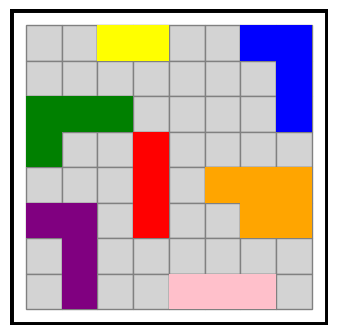

To a state incorporating the following block position(s):


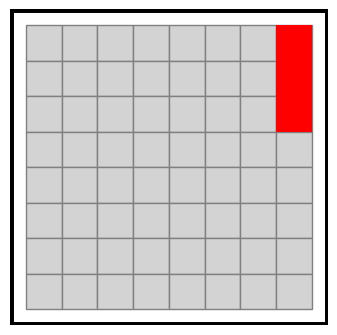


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 328
Goal state is:


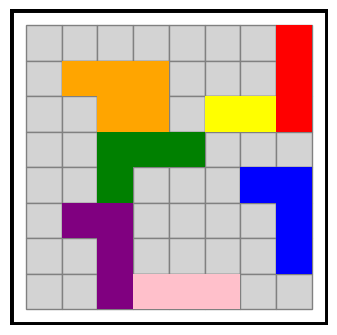


SEARCH SPACE STATS:
Total nodes generated          =     4251  (includes start)
Nodes discarded by loop_check  =      667  (3584 distinct states added to queue)
Nodes tested (by goal_test)    =      329  (328 expanded + 1 goal)
Nodes left in queue            =     3255

Time taken = 0.1815 seconds

Solve the following sliding blocks problem.
Get from this initial state:


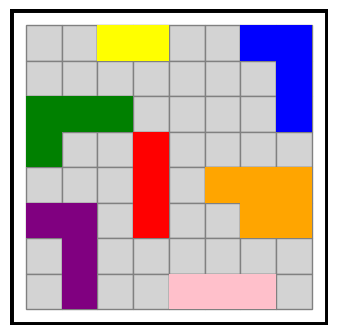

To a state incorporating the following block position(s):


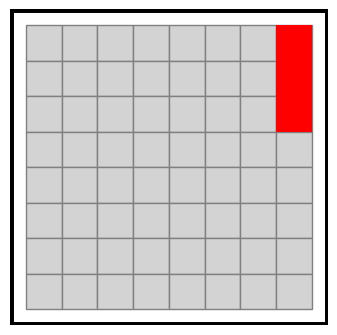


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   639050  (includes start)
Nodes discarded by loop_check  =   539049  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39353  (all expanded)
Nodes left in queue            =    60647

Time taken = 19.2841 seconds

Solve the following sliding blocks problem.
Get from this initial state:


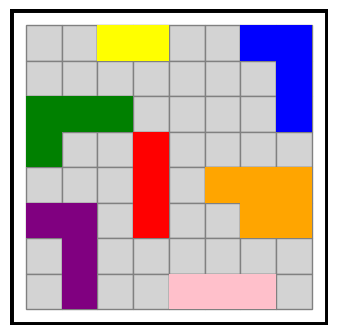

To a state incorporating the following block position(s):


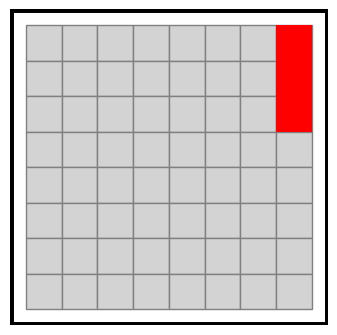


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 282
Goal state is:


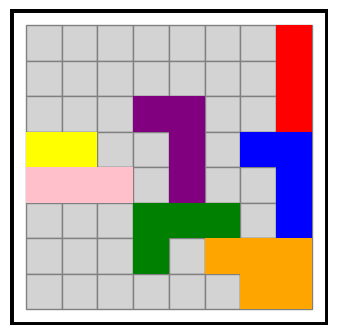


SEARCH SPACE STATS:
Total nodes generated          =     3793  (includes start)
Nodes discarded by loop_check  =      590  (3203 distinct states added to queue)
Nodes tested (by goal_test)    =      283  (282 expanded + 1 goal)
Nodes left in queue            =     2920

Time taken = 0.1679 seconds

Solve the following sliding blocks problem.
Get from this initial state:


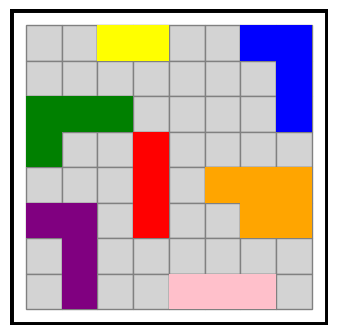

To a state incorporating the following block position(s):


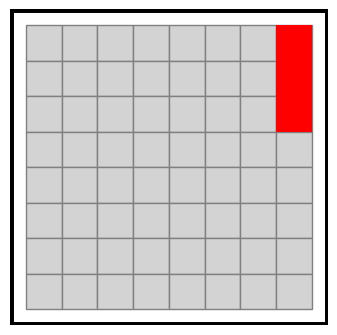


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121209  (includes start)
Nodes discarded by loop_check  =    21208  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9850  (all expanded)
Nodes left in queue            =    90150

Time taken = 20.0211 seconds

Solve the following sliding blocks problem.
Get from this initial state:


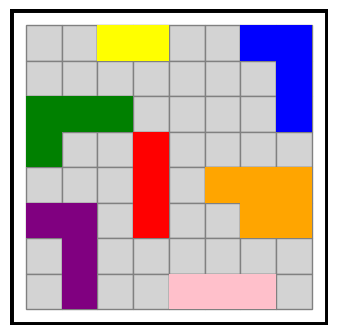

To a state incorporating the following block position(s):


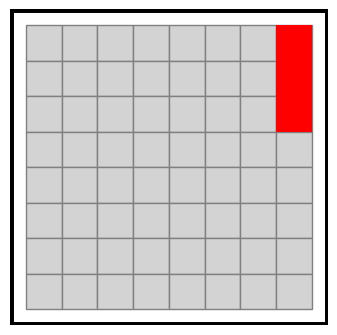


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 59
Goal state is:


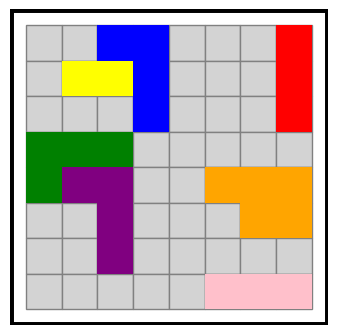


SEARCH SPACE STATS:
Total nodes generated          =      855  (includes start)
Nodes discarded by loop_check  =      118  (737 distinct states added to queue)
Nodes tested (by goal_test)    =       60  (59 expanded + 1 goal)
Nodes left in queue            =      677

Time taken = 0.0746 seconds

Solve the following sliding blocks problem.
Get from this initial state:


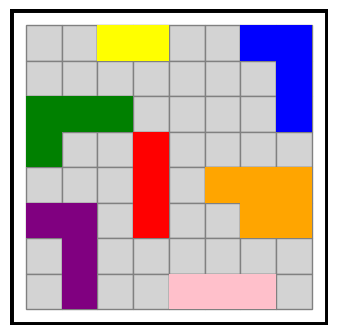

To a state incorporating the following block position(s):


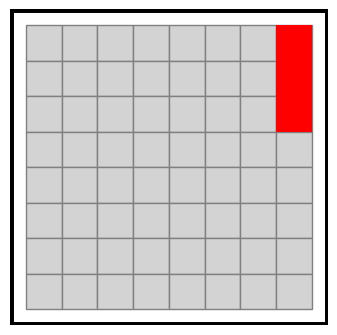


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


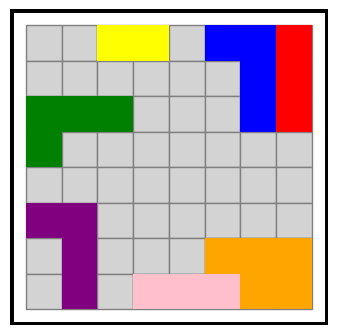

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   132380  (includes start)
Nodes discarded by loop_check  =   100628  (31752 distinct states added to queue)
Nodes tested (by goal_test)    =     8078  (8077 expanded + 1 goal)
Nodes left in queue            =    23674

Time taken = 24.1626 seconds

Solve the following sliding blocks problem.
Get from this initial state:


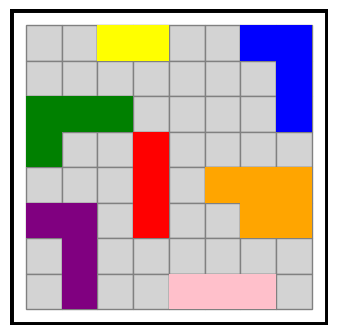

To a state incorporating the following block position(s):


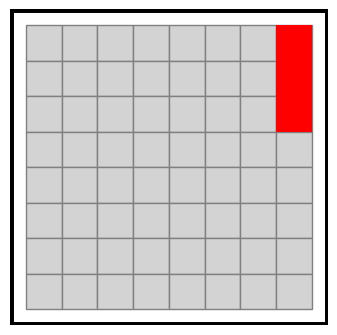


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   571426  (includes start)
Nodes discarded by loop_check  =   471425  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35562  (all expanded)
Nodes left in queue            =    64438

Time taken = 18.1432 seconds

Solve the following sliding blocks problem.
Get from this initial state:


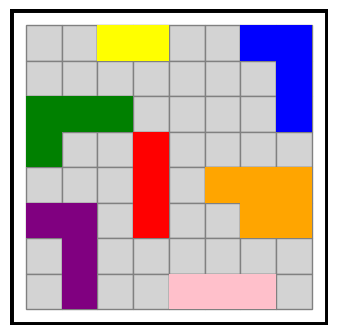

To a state incorporating the following block position(s):


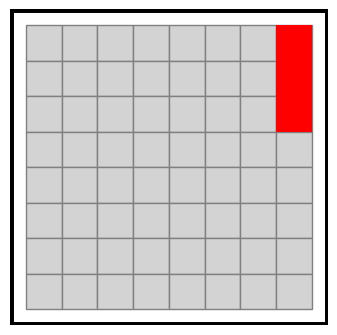


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   524938  (includes start)
Nodes discarded by loop_check  =   424937  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32085  (all expanded)
Nodes left in queue            =    67915

Time taken = 17.8288 seconds

Solve the following sliding blocks problem.
Get from this initial state:


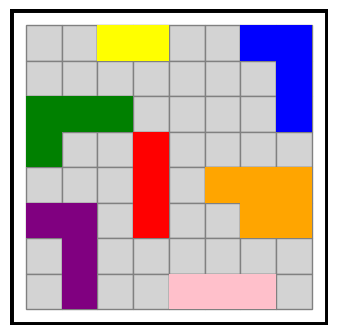

To a state incorporating the following block position(s):


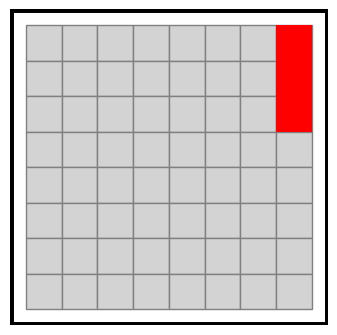


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......
:-)) *SUCCESS* ((-:

Path length = 7295
Goal state is:


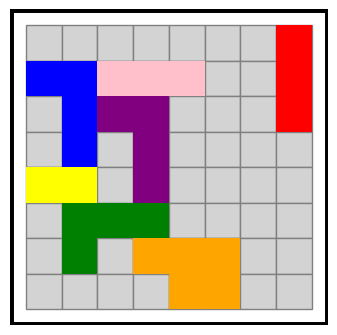


SEARCH SPACE STATS:
Total nodes generated          =   100259  (includes start)
Nodes discarded by loop_check  =    14839  (85420 distinct states added to queue)
Nodes tested (by goal_test)    =     7296  (7295 expanded + 1 goal)
Nodes left in queue            =    78124

Time taken = 12.2477 seconds

Solve the following sliding blocks problem.
Get from this initial state:


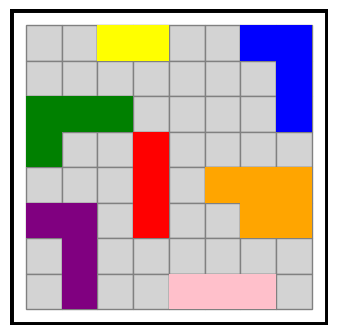

To a state incorporating the following block position(s):


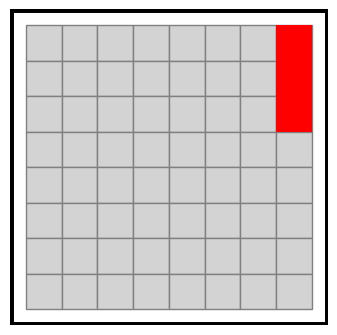


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   639020  (includes start)
Nodes discarded by loop_check  =   539019  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39497  (all expanded)
Nodes left in queue            =    60503

Time taken = 25.689 seconds

Solve the following sliding blocks problem.
Get from this initial state:


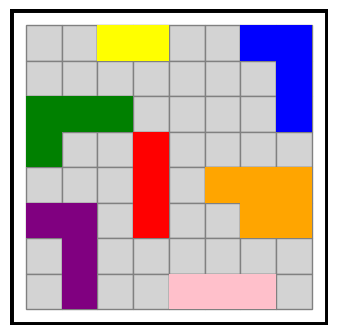

To a state incorporating the following block position(s):


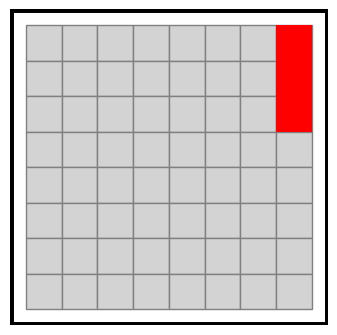


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 95
Goal state is:


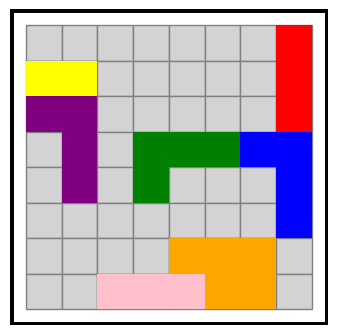


SEARCH SPACE STATS:
Total nodes generated          =     1347  (includes start)
Nodes discarded by loop_check  =      202  (1145 distinct states added to queue)
Nodes tested (by goal_test)    =       96  (95 expanded + 1 goal)
Nodes left in queue            =     1049

Time taken = 0.0832 seconds

Solve the following sliding blocks problem.
Get from this initial state:


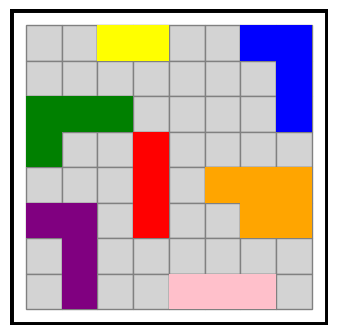

To a state incorporating the following block position(s):


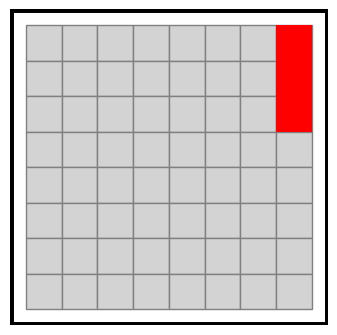


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121047  (includes start)
Nodes discarded by loop_check  =    21046  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9882  (all expanded)
Nodes left in queue            =    90118

Time taken = 19.9481 seconds

Solve the following sliding blocks problem.
Get from this initial state:


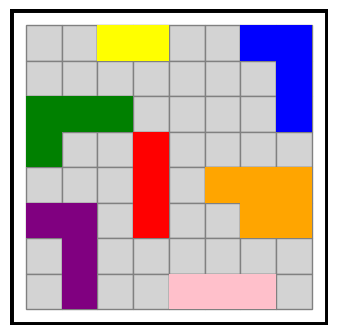

To a state incorporating the following block position(s):


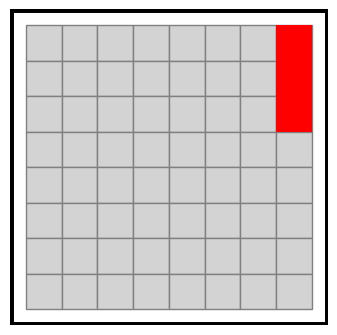


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120667  (includes start)
Nodes discarded by loop_check  =    20666  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9850  (all expanded)
Nodes left in queue            =    90150

Time taken = 38.0932 seconds

Solve the following sliding blocks problem.
Get from this initial state:


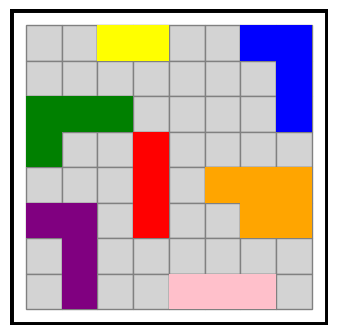

To a state incorporating the following block position(s):


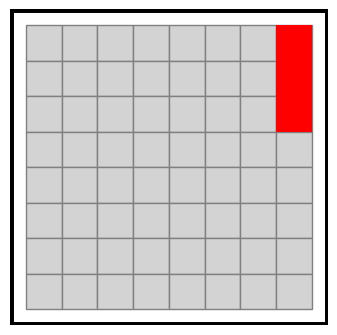


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


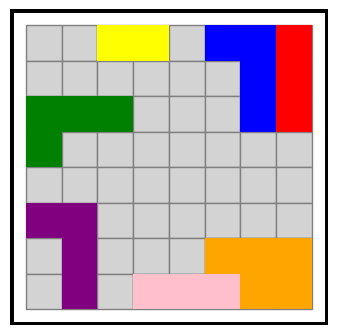

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   143218  (includes start)
Nodes discarded by loop_check  =   109623  (33595 distinct states added to queue)
Nodes tested (by goal_test)    =     8752  (8751 expanded + 1 goal)
Nodes left in queue            =    24843

Time taken = 21.9764 seconds

Solve the following sliding blocks problem.
Get from this initial state:


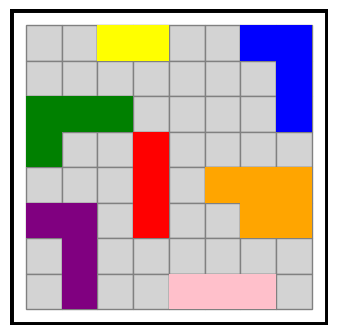

To a state incorporating the following block position(s):


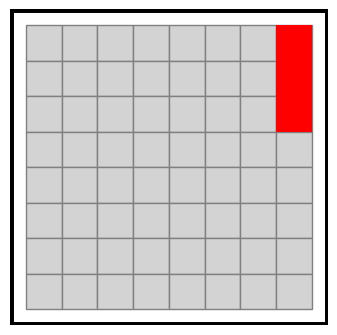


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570391  (includes start)
Nodes discarded by loop_check  =   470390  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35495  (all expanded)
Nodes left in queue            =    64505

Time taken = 18.5155 seconds

Solve the following sliding blocks problem.
Get from this initial state:


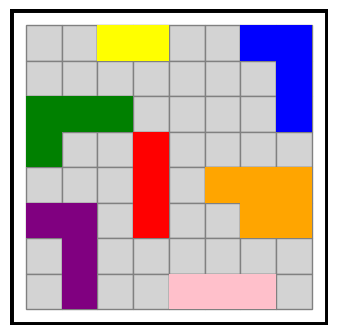

To a state incorporating the following block position(s):


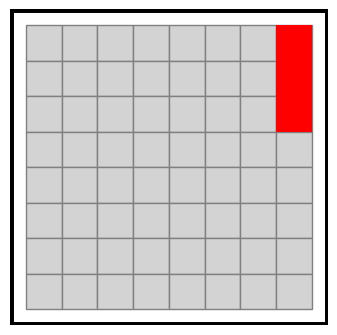


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...............................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   521674  (includes start)
Nodes discarded by loop_check  =   421673  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    31935  (all expanded)
Nodes left in queue            =    68065

Time taken = 18.074 seconds

Solve the following sliding blocks problem.
Get from this initial state:


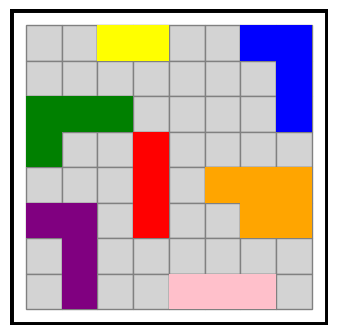

To a state incorporating the following block position(s):


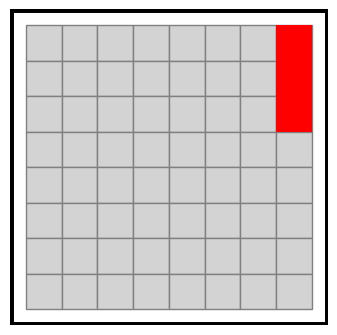


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
......
:-)) *SUCCESS* ((-:

Path length = 6355
Goal state is:


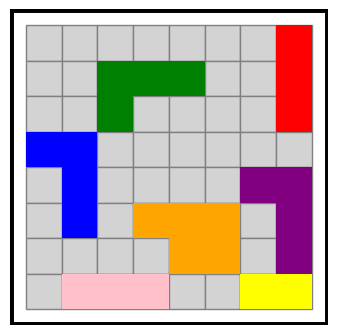


SEARCH SPACE STATS:
Total nodes generated          =    86850  (includes start)
Nodes discarded by loop_check  =    12994  (73856 distinct states added to queue)
Nodes tested (by goal_test)    =     6356  (6355 expanded + 1 goal)
Nodes left in queue            =    67500

Time taken = 9.71 seconds

Solve the following sliding blocks problem.
Get from this initial state:


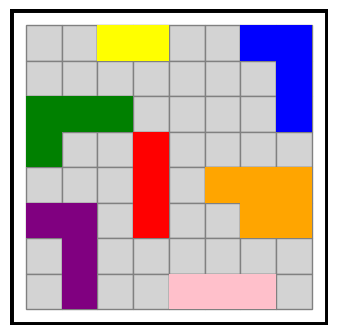

To a state incorporating the following block position(s):


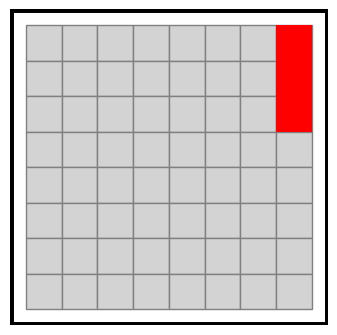


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   643991  (includes start)
Nodes discarded by loop_check  =   543990  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39684  (all expanded)
Nodes left in queue            =    60316

Time taken = 23.8731 seconds

Solve the following sliding blocks problem.
Get from this initial state:


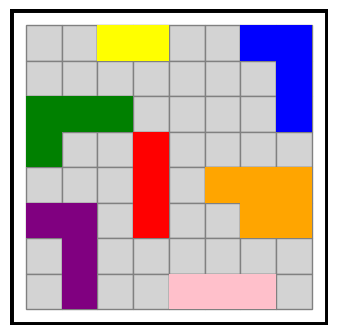

To a state incorporating the following block position(s):


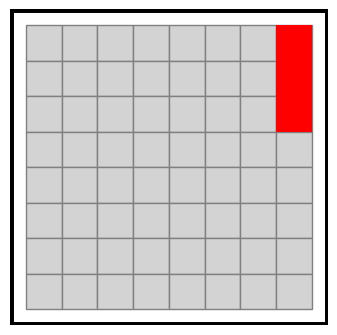


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 79
Goal state is:


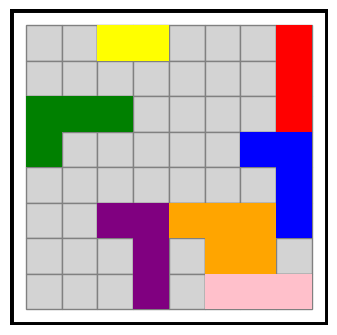


SEARCH SPACE STATS:
Total nodes generated          =     1223  (includes start)
Nodes discarded by loop_check  =      169  (1054 distinct states added to queue)
Nodes tested (by goal_test)    =       80  (79 expanded + 1 goal)
Nodes left in queue            =      974

Time taken = 0.0766 seconds

Solve the following sliding blocks problem.
Get from this initial state:


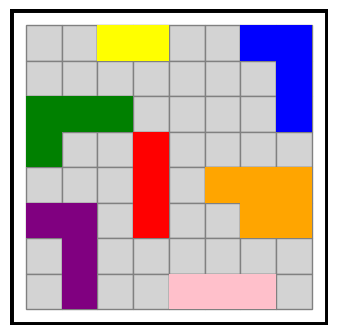

To a state incorporating the following block position(s):


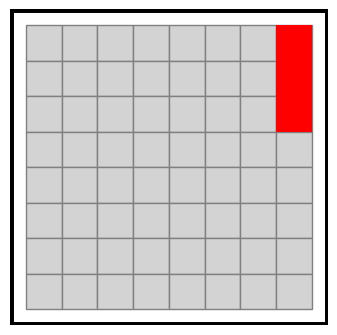


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121086  (includes start)
Nodes discarded by loop_check  =    21085  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9828  (all expanded)
Nodes left in queue            =    90172

Time taken = 21.4145 seconds

Solve the following sliding blocks problem.
Get from this initial state:


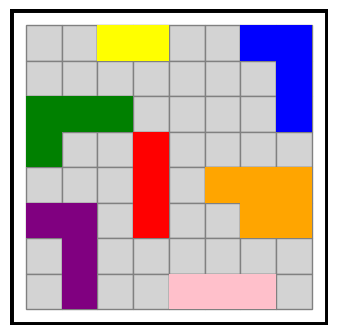

To a state incorporating the following block position(s):


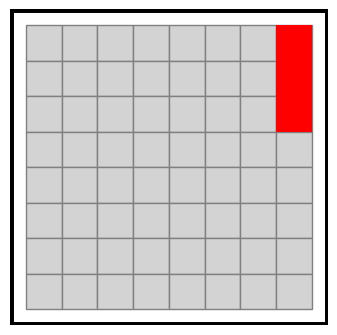


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121071  (includes start)
Nodes discarded by loop_check  =    21070  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9866  (all expanded)
Nodes left in queue            =    90134

Time taken = 43.9879 seconds

Solve the following sliding blocks problem.
Get from this initial state:


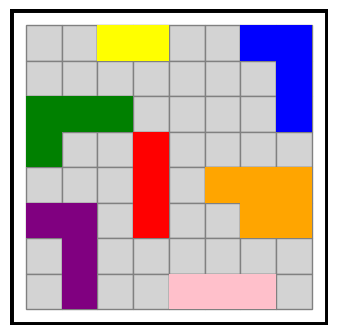

To a state incorporating the following block position(s):


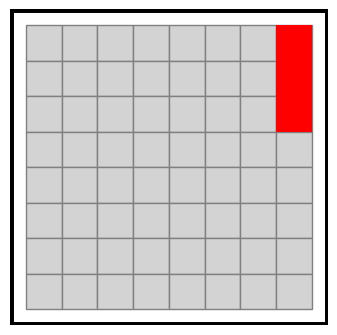


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...............
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


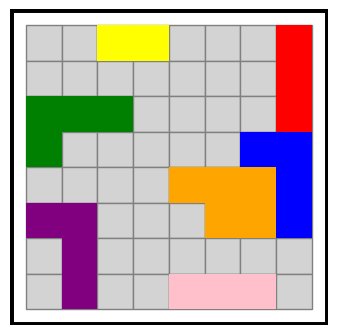

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   242563  (includes start)
Nodes discarded by loop_check  =   193683  (48880 distinct states added to queue)
Nodes tested (by goal_test)    =    15030  (15029 expanded + 1 goal)
Nodes left in queue            =    33850

Time taken = 25.8224 seconds

Solve the following sliding blocks problem.
Get from this initial state:


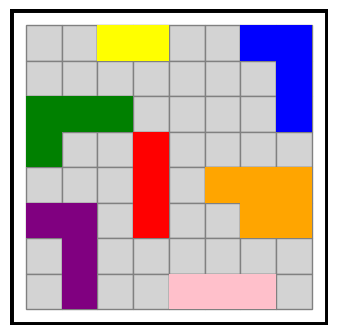

To a state incorporating the following block position(s):


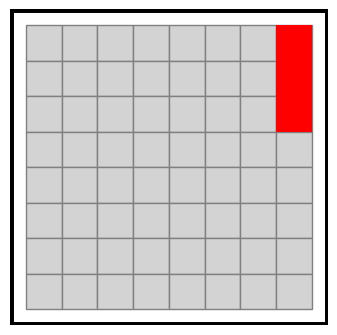


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570589  (includes start)
Nodes discarded by loop_check  =   470588  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35515  (all expanded)
Nodes left in queue            =    64485

Time taken = 18.7073 seconds

Solve the following sliding blocks problem.
Get from this initial state:


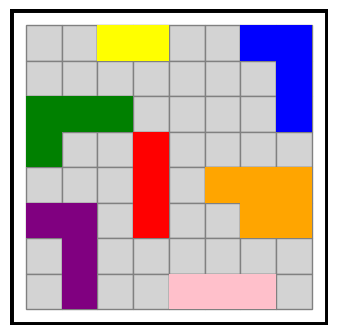

To a state incorporating the following block position(s):


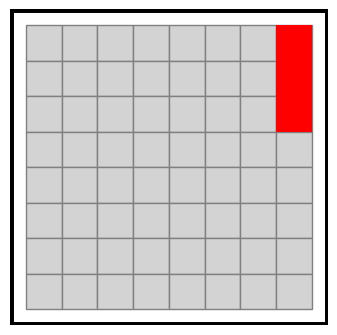


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   524781  (includes start)
Nodes discarded by loop_check  =   424780  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32314  (all expanded)
Nodes left in queue            =    67686

Time taken = 18.5687 seconds

Solve the following sliding blocks problem.
Get from this initial state:


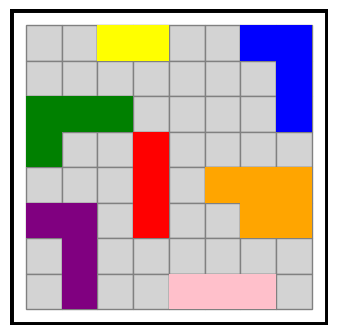

To a state incorporating the following block position(s):


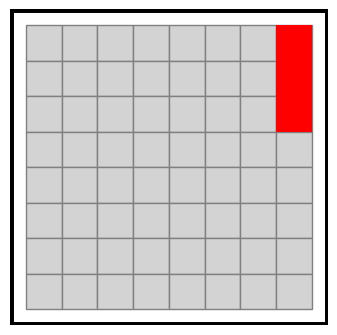


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1243
Goal state is:


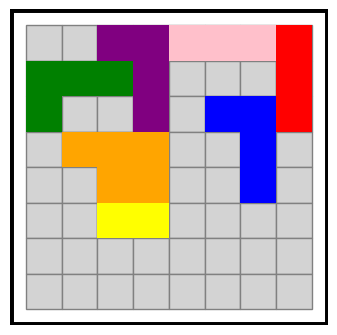


SEARCH SPACE STATS:
Total nodes generated          =    17015  (includes start)
Nodes discarded by loop_check  =     2567  (14448 distinct states added to queue)
Nodes tested (by goal_test)    =     1244  (1243 expanded + 1 goal)
Nodes left in queue            =    13204

Time taken = 0.6662 seconds

Solve the following sliding blocks problem.
Get from this initial state:


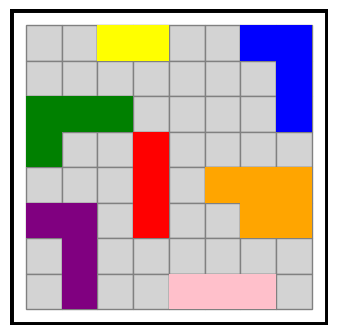

To a state incorporating the following block position(s):


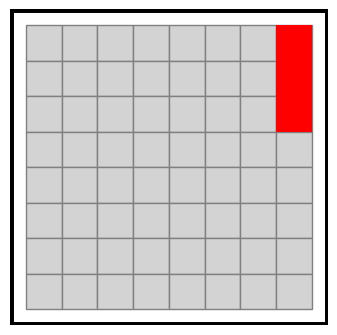


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   639082  (includes start)
Nodes discarded by loop_check  =   539081  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39297  (all expanded)
Nodes left in queue            =    60703

Time taken = 20.7547 seconds

Solve the following sliding blocks problem.
Get from this initial state:


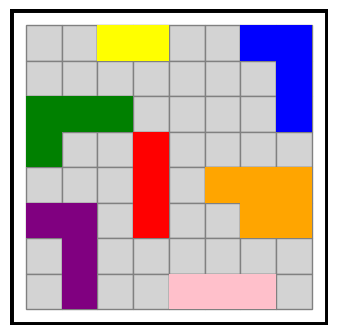

To a state incorporating the following block position(s):


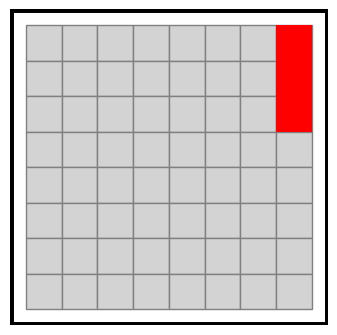


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 131
Goal state is:


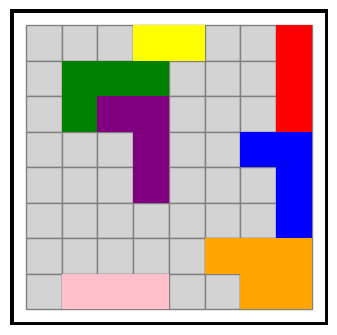


SEARCH SPACE STATS:
Total nodes generated          =     1822  (includes start)
Nodes discarded by loop_check  =      264  (1558 distinct states added to queue)
Nodes tested (by goal_test)    =      132  (131 expanded + 1 goal)
Nodes left in queue            =     1426

Time taken = 0.1031 seconds

Solve the following sliding blocks problem.
Get from this initial state:


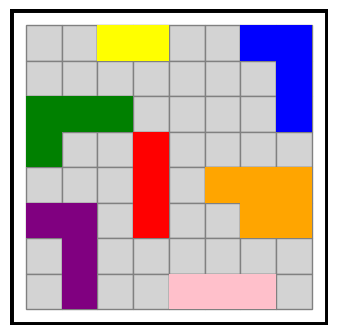

To a state incorporating the following block position(s):


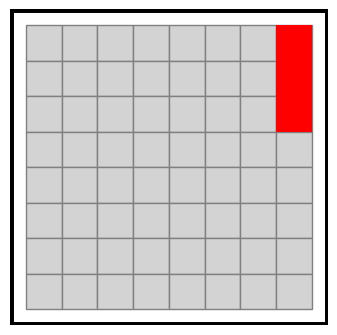


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121225  (includes start)
Nodes discarded by loop_check  =    21224  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9809  (all expanded)
Nodes left in queue            =    90191

Time taken = 21.8303 seconds

Solve the following sliding blocks problem.
Get from this initial state:


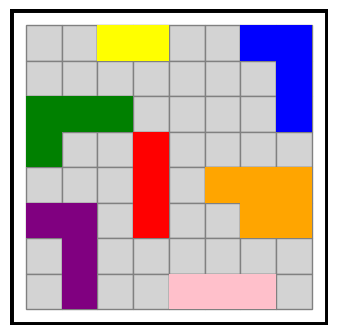

To a state incorporating the following block position(s):


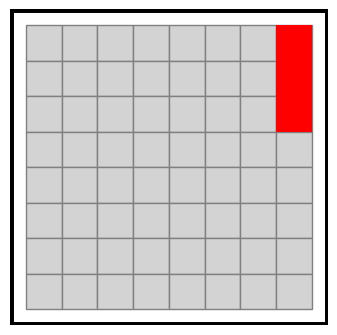


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120803  (includes start)
Nodes discarded by loop_check  =    20802  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9756  (all expanded)
Nodes left in queue            =    90244

Time taken = 44.4375 seconds

Solve the following sliding blocks problem.
Get from this initial state:


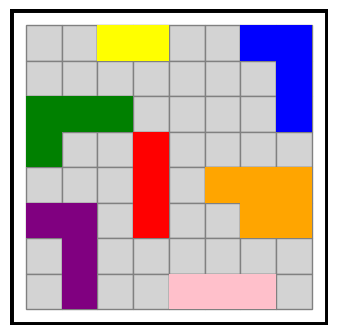

To a state incorporating the following block position(s):


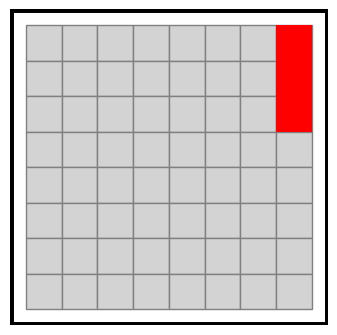


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


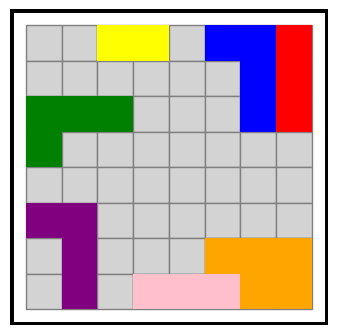

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   142596  (includes start)
Nodes discarded by loop_check  =   109065  (33531 distinct states added to queue)
Nodes tested (by goal_test)    =     8718  (8717 expanded + 1 goal)
Nodes left in queue            =    24813

Time taken = 23.7308 seconds

Solve the following sliding blocks problem.
Get from this initial state:


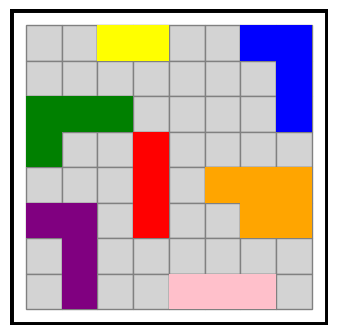

To a state incorporating the following block position(s):


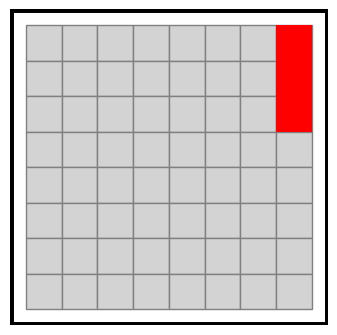


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570734  (includes start)
Nodes discarded by loop_check  =   470733  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35513  (all expanded)
Nodes left in queue            =    64487

Time taken = 18.7546 seconds

Solve the following sliding blocks problem.
Get from this initial state:


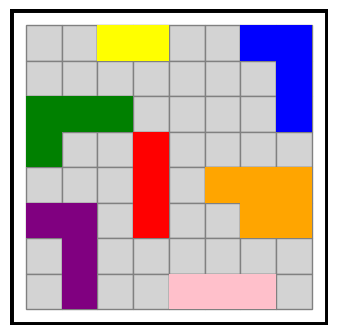

To a state incorporating the following block position(s):


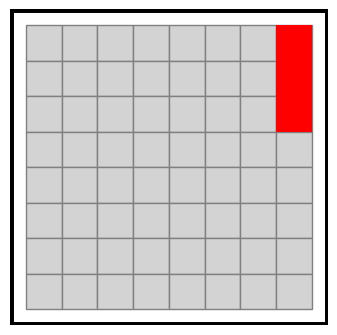


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...............................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   516506  (includes start)
Nodes discarded by loop_check  =   416505  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    31717  (all expanded)
Nodes left in queue            =    68283

Time taken = 18.1965 seconds

Solve the following sliding blocks problem.
Get from this initial state:


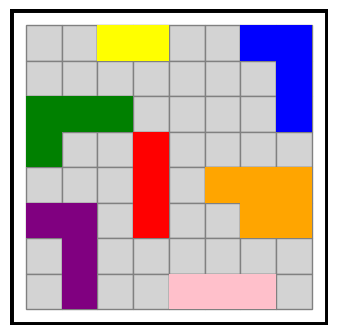

To a state incorporating the following block position(s):


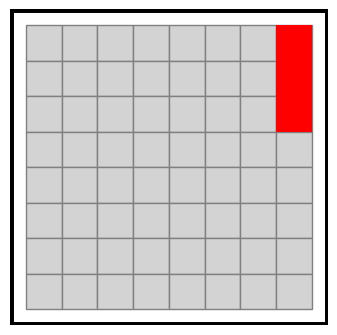


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..
:-)) *SUCCESS* ((-:

Path length = 2671
Goal state is:


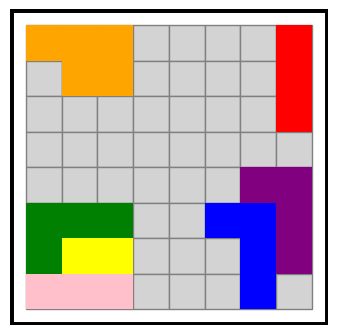


SEARCH SPACE STATS:
Total nodes generated          =    37100  (includes start)
Nodes discarded by loop_check  =     5421  (31679 distinct states added to queue)
Nodes tested (by goal_test)    =     2672  (2671 expanded + 1 goal)
Nodes left in queue            =    29007

Time taken = 2.8432 seconds

Solve the following sliding blocks problem.
Get from this initial state:


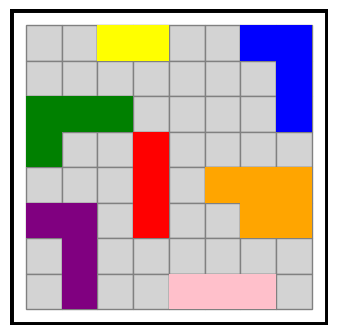

To a state incorporating the following block position(s):


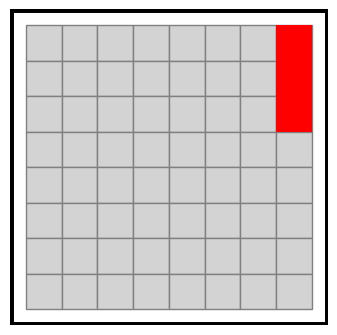


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   641391  (includes start)
Nodes discarded by loop_check  =   541390  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39646  (all expanded)
Nodes left in queue            =    60354

Time taken = 20.4665 seconds

Solve the following sliding blocks problem.
Get from this initial state:


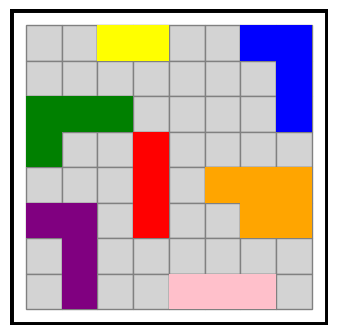

To a state incorporating the following block position(s):


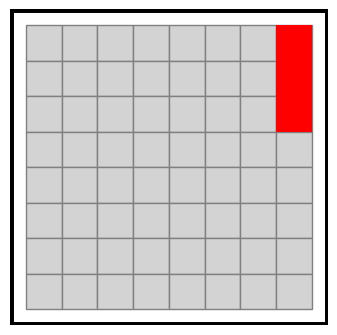


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 46
Goal state is:


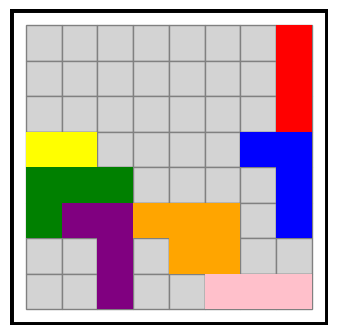


SEARCH SPACE STATS:
Total nodes generated          =      614  (includes start)
Nodes discarded by loop_check  =       92  (522 distinct states added to queue)
Nodes tested (by goal_test)    =       47  (46 expanded + 1 goal)
Nodes left in queue            =      475

Time taken = 0.0591 seconds

Solve the following sliding blocks problem.
Get from this initial state:


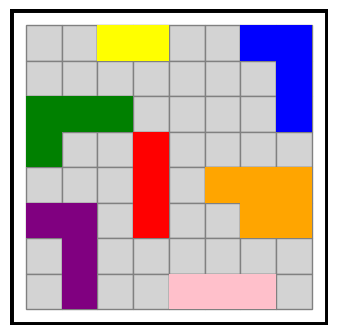

To a state incorporating the following block position(s):


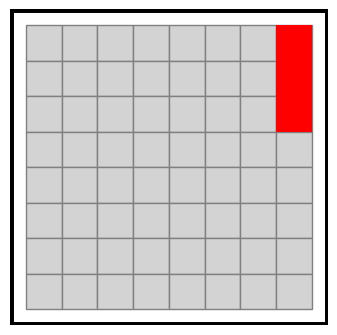


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121179  (includes start)
Nodes discarded by loop_check  =    21178  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9779  (all expanded)
Nodes left in queue            =    90221

Time taken = 21.899 seconds

Solve the following sliding blocks problem.
Get from this initial state:


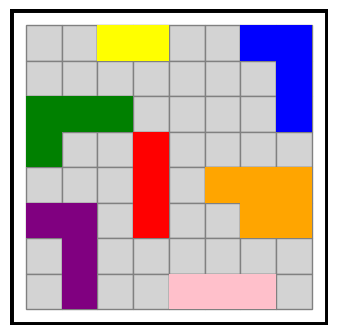

To a state incorporating the following block position(s):


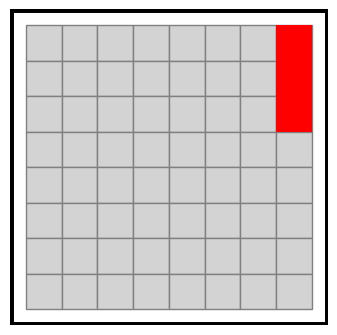


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121228  (includes start)
Nodes discarded by loop_check  =    21227  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9894  (all expanded)
Nodes left in queue            =    90106

Time taken = 54.1982 seconds

Solve the following sliding blocks problem.
Get from this initial state:


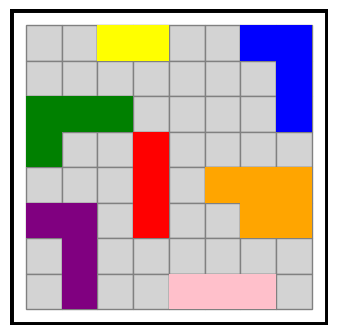

To a state incorporating the following block position(s):


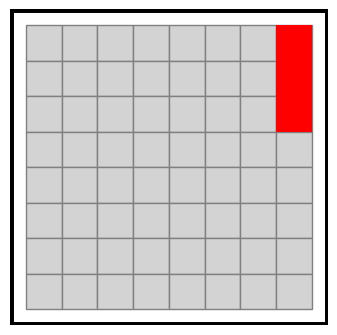


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


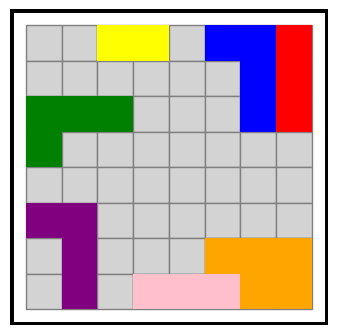

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   135673  (includes start)
Nodes discarded by loop_check  =   103223  (32450 distinct states added to queue)
Nodes tested (by goal_test)    =     8309  (8308 expanded + 1 goal)
Nodes left in queue            =    24141

Time taken = 25.1462 seconds

Solve the following sliding blocks problem.
Get from this initial state:


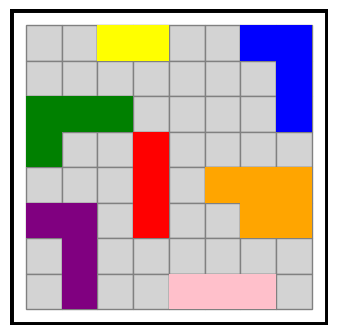

To a state incorporating the following block position(s):


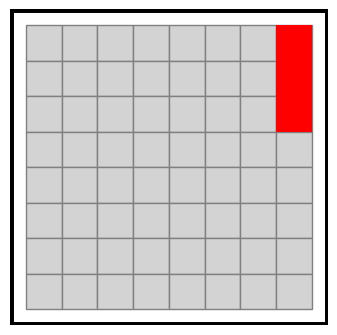


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   571308  (includes start)
Nodes discarded by loop_check  =   471307  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35560  (all expanded)
Nodes left in queue            =    64440

Time taken = 19.0506 seconds

Solve the following sliding blocks problem.
Get from this initial state:


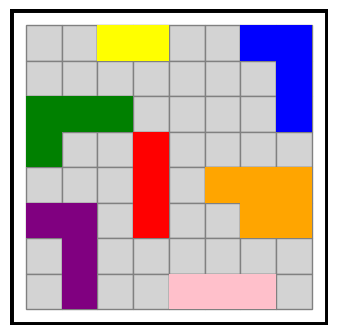

To a state incorporating the following block position(s):


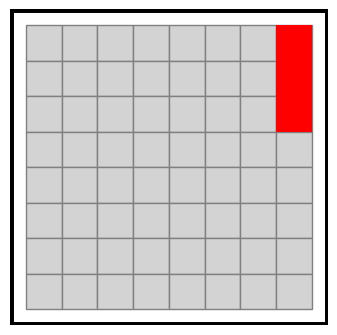


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   527884  (includes start)
Nodes discarded by loop_check  =   427883  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32469  (all expanded)
Nodes left in queue            =    67531

Time taken = 18.1964 seconds

Solve the following sliding blocks problem.
Get from this initial state:


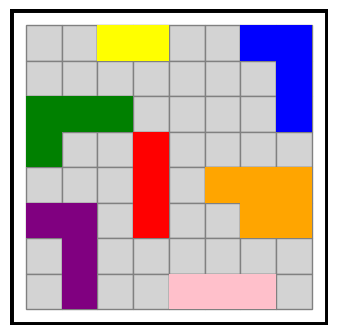

To a state incorporating the following block position(s):


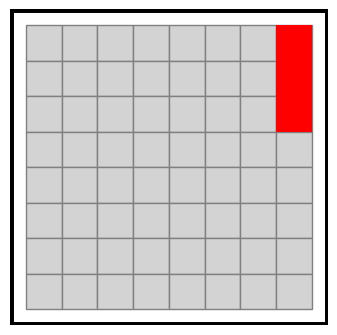


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 440
Goal state is:


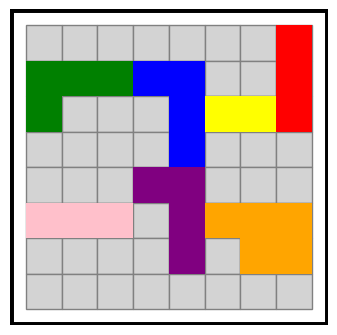


SEARCH SPACE STATS:
Total nodes generated          =     6278  (includes start)
Nodes discarded by loop_check  =      913  (5365 distinct states added to queue)
Nodes tested (by goal_test)    =      441  (440 expanded + 1 goal)
Nodes left in queue            =     4924

Time taken = 0.2552 seconds

Solve the following sliding blocks problem.
Get from this initial state:


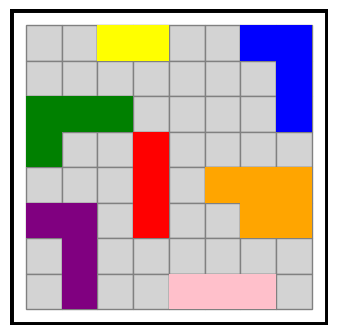

To a state incorporating the following block position(s):


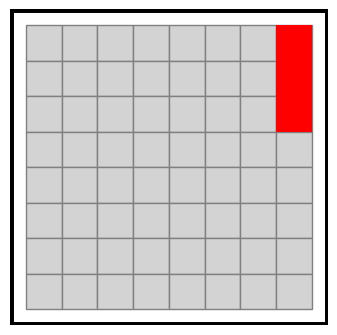


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   642536  (includes start)
Nodes discarded by loop_check  =   542535  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39648  (all expanded)
Nodes left in queue            =    60352

Time taken = 20.6822 seconds

Solve the following sliding blocks problem.
Get from this initial state:


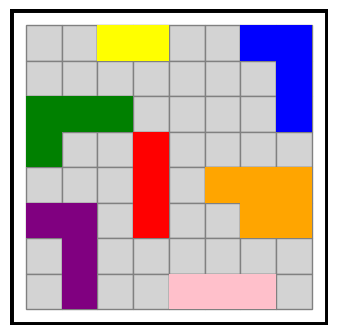

To a state incorporating the following block position(s):


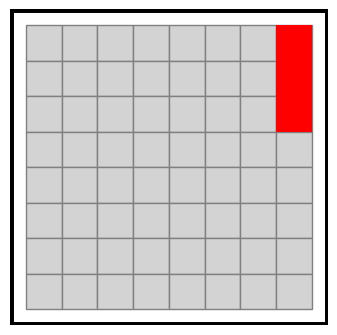


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 276
Goal state is:


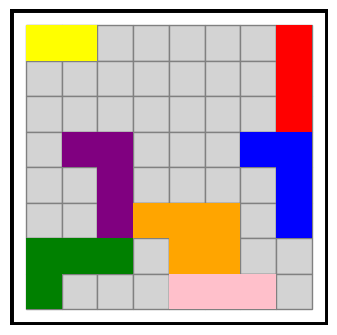


SEARCH SPACE STATS:
Total nodes generated          =     3756  (includes start)
Nodes discarded by loop_check  =      573  (3183 distinct states added to queue)
Nodes tested (by goal_test)    =      277  (276 expanded + 1 goal)
Nodes left in queue            =     2906

Time taken = 0.1673 seconds

Solve the following sliding blocks problem.
Get from this initial state:


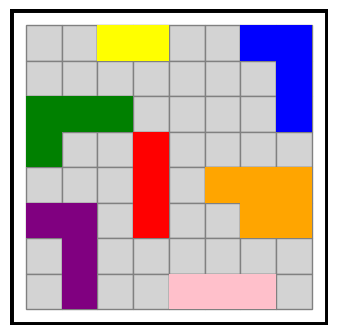

To a state incorporating the following block position(s):


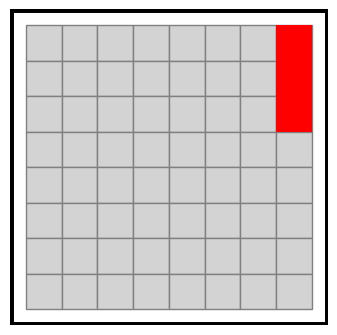


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121156  (includes start)
Nodes discarded by loop_check  =    21155  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9898  (all expanded)
Nodes left in queue            =    90102

Time taken = 20.4172 seconds

Solve the following sliding blocks problem.
Get from this initial state:


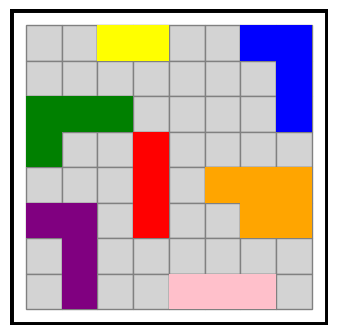

To a state incorporating the following block position(s):


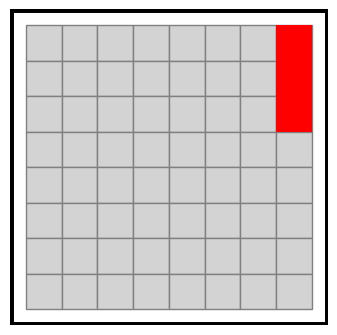


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120940  (includes start)
Nodes discarded by loop_check  =    20939  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9853  (all expanded)
Nodes left in queue            =    90147

Time taken = 40.1979 seconds

Solve the following sliding blocks problem.
Get from this initial state:


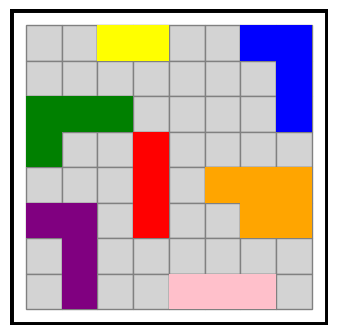

To a state incorporating the following block position(s):


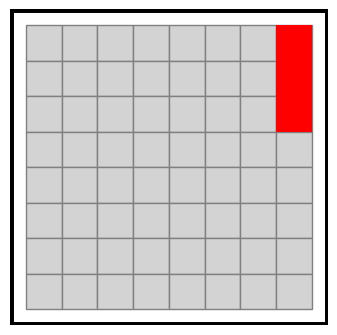


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..............
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


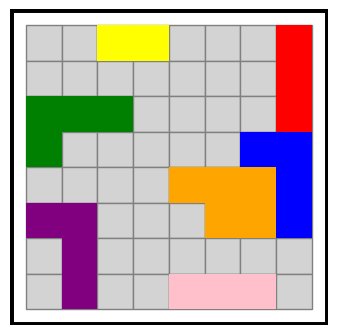

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   241400  (includes start)
Nodes discarded by loop_check  =   192637  (48763 distinct states added to queue)
Nodes tested (by goal_test)    =    14969  (14968 expanded + 1 goal)
Nodes left in queue            =    33794

Time taken = 26.3414 seconds

Solve the following sliding blocks problem.
Get from this initial state:


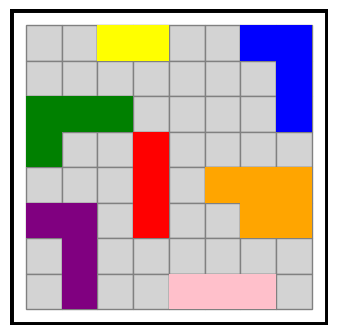

To a state incorporating the following block position(s):


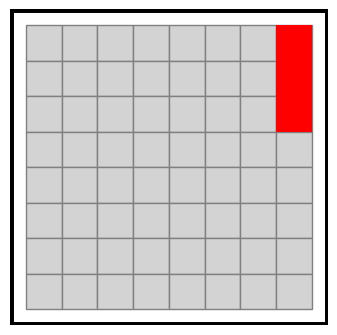


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570396  (includes start)
Nodes discarded by loop_check  =   470395  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35504  (all expanded)
Nodes left in queue            =    64496

Time taken = 18.5124 seconds

Solve the following sliding blocks problem.
Get from this initial state:


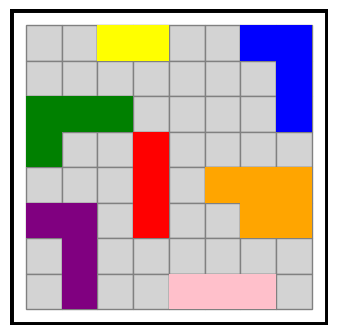

To a state incorporating the following block position(s):


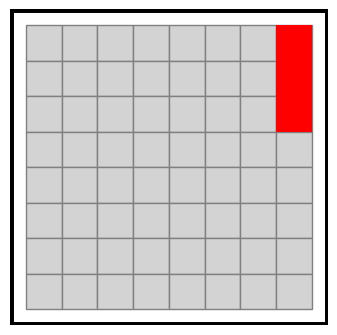


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   530161  (includes start)
Nodes discarded by loop_check  =   430160  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32420  (all expanded)
Nodes left in queue            =    67580

Time taken = 17.8684 seconds

Solve the following sliding blocks problem.
Get from this initial state:


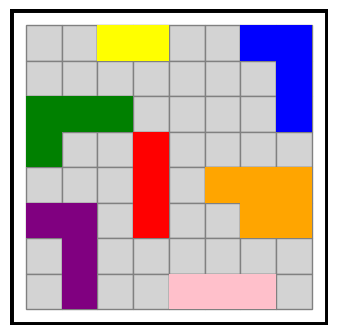

To a state incorporating the following block position(s):


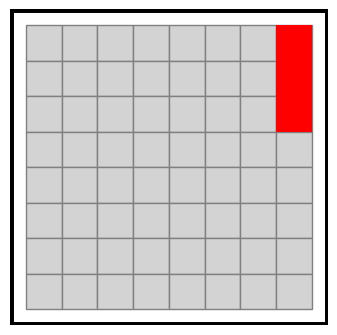


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..
:-)) *SUCCESS* ((-:

Path length = 2131
Goal state is:


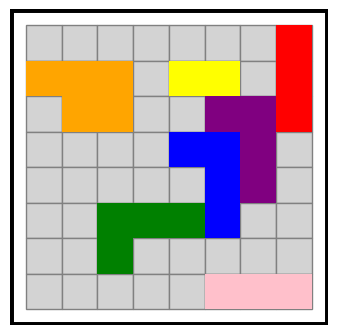


SEARCH SPACE STATS:
Total nodes generated          =    29587  (includes start)
Nodes discarded by loop_check  =     4336  (25251 distinct states added to queue)
Nodes tested (by goal_test)    =     2132  (2131 expanded + 1 goal)
Nodes left in queue            =    23119

Time taken = 2.4762 seconds

Solve the following sliding blocks problem.
Get from this initial state:


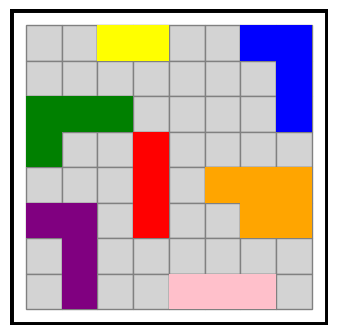

To a state incorporating the following block position(s):


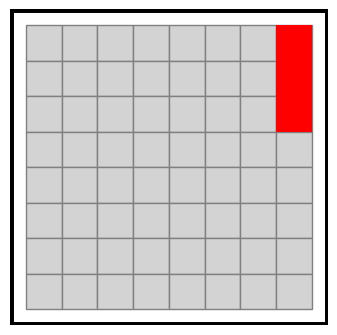


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   641952  (includes start)
Nodes discarded by loop_check  =   541951  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39670  (all expanded)
Nodes left in queue            =    60330

Time taken = 20.5097 seconds

Solve the following sliding blocks problem.
Get from this initial state:


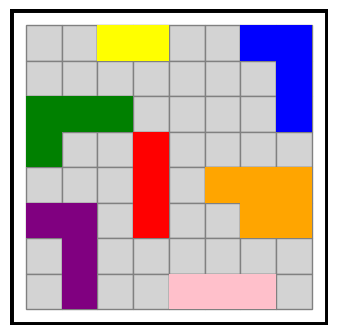

To a state incorporating the following block position(s):


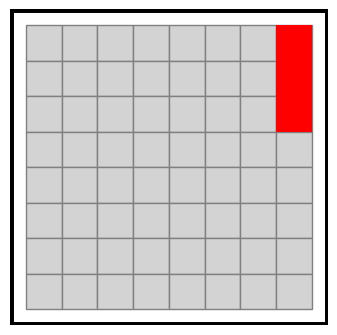


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120943  (includes start)
Nodes discarded by loop_check  =    20942  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9739  (all expanded)
Nodes left in queue            =    90261

Time taken = 20.0697 seconds

Solve the following sliding blocks problem.
Get from this initial state:


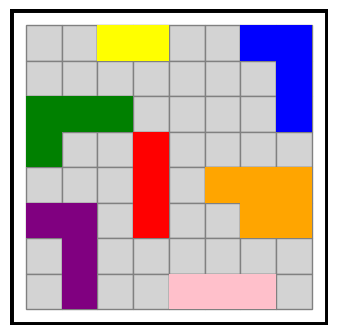

To a state incorporating the following block position(s):


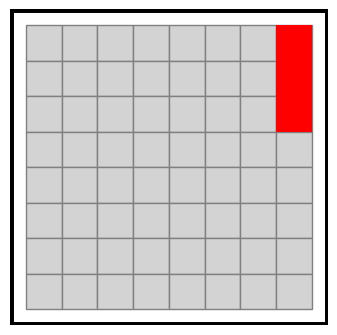


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120981  (includes start)
Nodes discarded by loop_check  =    20980  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9789  (all expanded)
Nodes left in queue            =    90211

Time taken = 38.2263 seconds

Solve the following sliding blocks problem.
Get from this initial state:


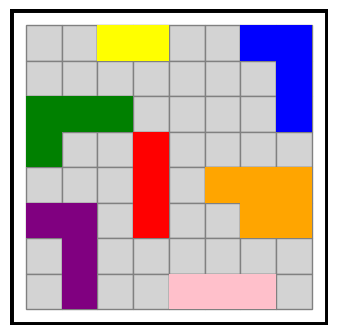

To a state incorporating the following block position(s):


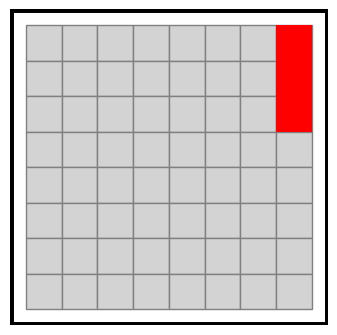


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120747  (includes start)
Nodes discarded by loop_check  =    20746  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9734  (all expanded)
Nodes left in queue            =    90266

Time taken = 39.0672 seconds

Solve the following sliding blocks problem.
Get from this initial state:


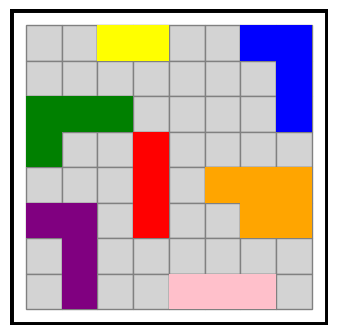

To a state incorporating the following block position(s):


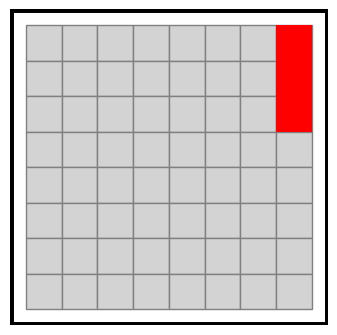


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


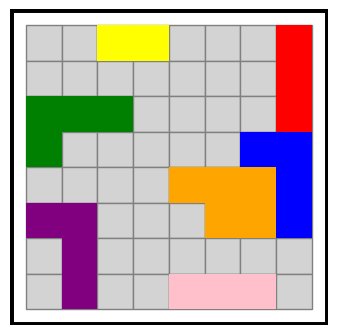

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   260291  (includes start)
Nodes discarded by loop_check  =   208488  (51803 distinct states added to queue)
Nodes tested (by goal_test)    =    16216  (16215 expanded + 1 goal)
Nodes left in queue            =    35587

Time taken = 27.1327 seconds

Solve the following sliding blocks problem.
Get from this initial state:


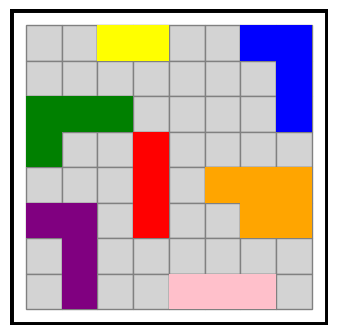

To a state incorporating the following block position(s):


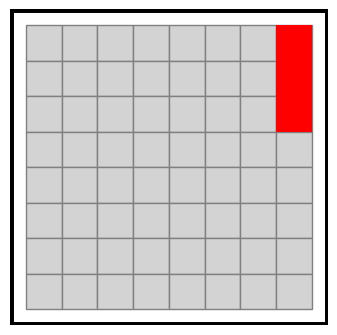


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570152  (includes start)
Nodes discarded by loop_check  =   470151  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35486  (all expanded)
Nodes left in queue            =    64514

Time taken = 19.0942 seconds

Solve the following sliding blocks problem.
Get from this initial state:


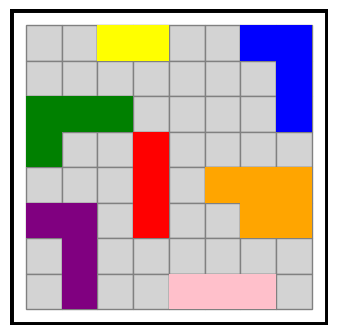

To a state incorporating the following block position(s):


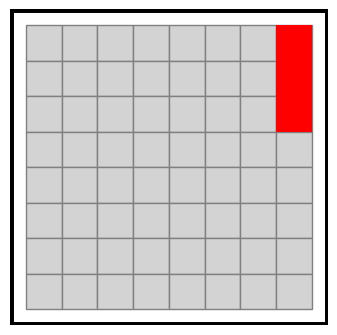


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...............................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   519764  (includes start)
Nodes discarded by loop_check  =   419763  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    31957  (all expanded)
Nodes left in queue            =    68043

Time taken = 18.6386 seconds

Solve the following sliding blocks problem.
Get from this initial state:


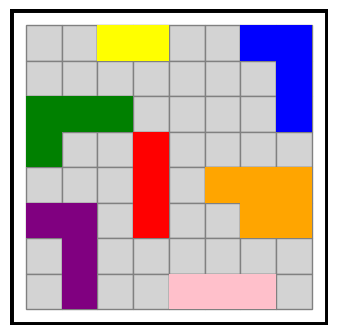

To a state incorporating the following block position(s):


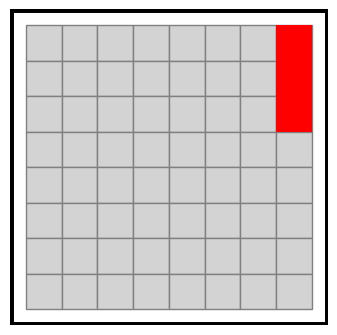


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1177
Goal state is:


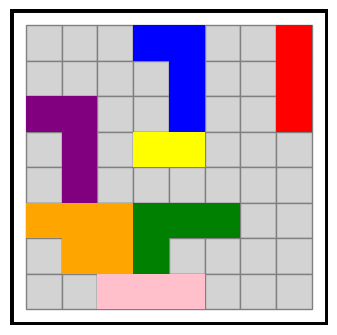


SEARCH SPACE STATS:
Total nodes generated          =    16651  (includes start)
Nodes discarded by loop_check  =     2375  (14276 distinct states added to queue)
Nodes tested (by goal_test)    =     1178  (1177 expanded + 1 goal)
Nodes left in queue            =    13098

Time taken = 0.649 seconds

Solve the following sliding blocks problem.
Get from this initial state:


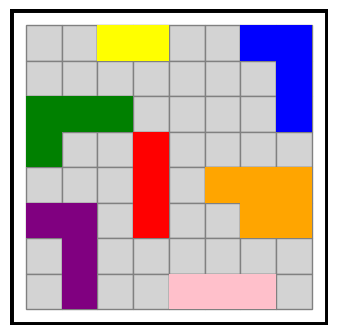

To a state incorporating the following block position(s):


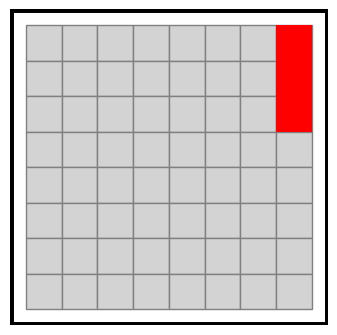


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   642671  (includes start)
Nodes discarded by loop_check  =   542670  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39677  (all expanded)
Nodes left in queue            =    60323

Time taken = 20.7786 seconds

Solve the following sliding blocks problem.
Get from this initial state:


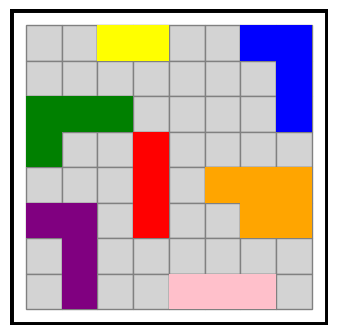

To a state incorporating the following block position(s):


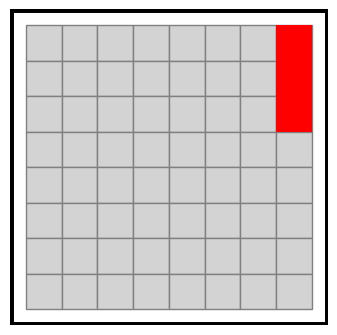


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 35
Goal state is:


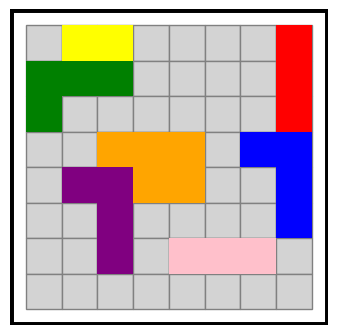


SEARCH SPACE STATS:
Total nodes generated          =      551  (includes start)
Nodes discarded by loop_check  =       69  (482 distinct states added to queue)
Nodes tested (by goal_test)    =       36  (35 expanded + 1 goal)
Nodes left in queue            =      446

Time taken = 0.0623 seconds

Solve the following sliding blocks problem.
Get from this initial state:


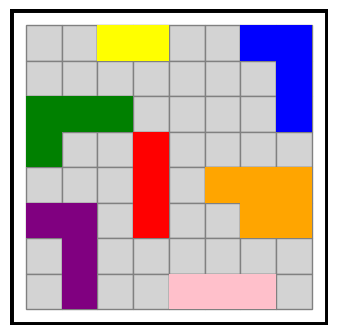

To a state incorporating the following block position(s):


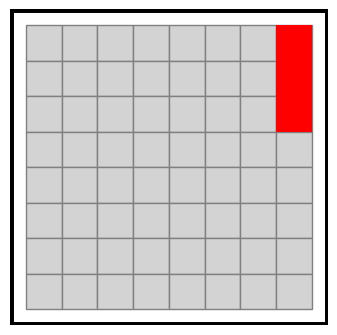


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120855  (includes start)
Nodes discarded by loop_check  =    20854  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9775  (all expanded)
Nodes left in queue            =    90225

Time taken = 21.3849 seconds

Solve the following sliding blocks problem.
Get from this initial state:


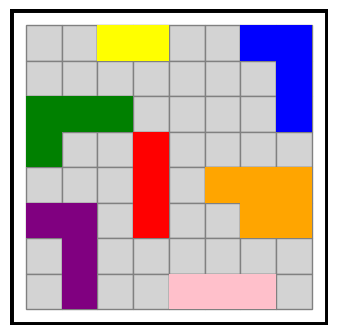

To a state incorporating the following block position(s):


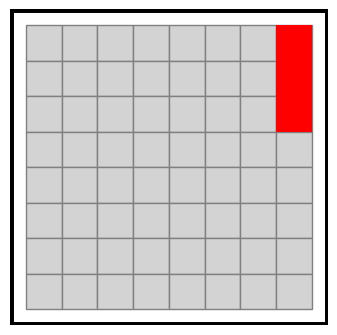


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120816  (includes start)
Nodes discarded by loop_check  =    20815  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9804  (all expanded)
Nodes left in queue            =    90196

Time taken = 39.1369 seconds

Solve the following sliding blocks problem.
Get from this initial state:


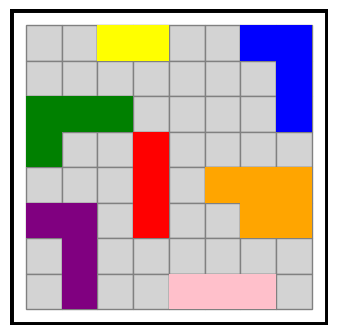

To a state incorporating the following block position(s):


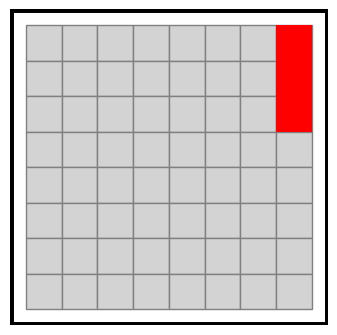


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


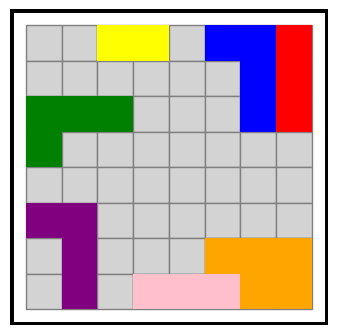

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   143840  (includes start)
Nodes discarded by loop_check  =   110145  (33695 distinct states added to queue)
Nodes tested (by goal_test)    =     8799  (8798 expanded + 1 goal)
Nodes left in queue            =    24896

Time taken = 23.0295 seconds

Solve the following sliding blocks problem.
Get from this initial state:


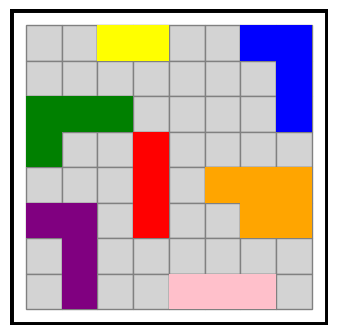

To a state incorporating the following block position(s):


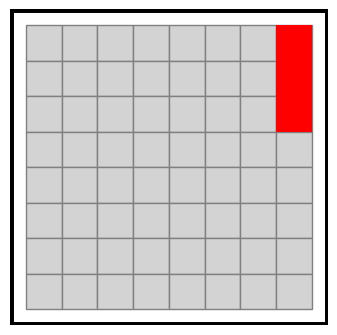


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570531  (includes start)
Nodes discarded by loop_check  =   470530  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35510  (all expanded)
Nodes left in queue            =    64490

Time taken = 19.6632 seconds

Solve the following sliding blocks problem.
Get from this initial state:


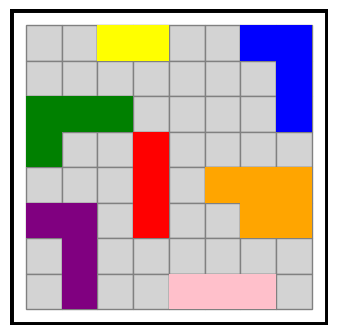

To a state incorporating the following block position(s):


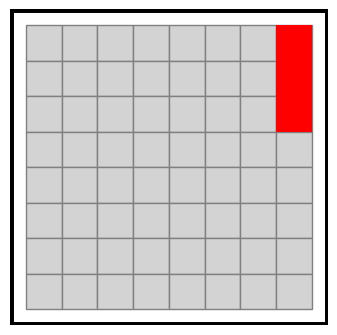


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   526086  (includes start)
Nodes discarded by loop_check  =   426085  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32541  (all expanded)
Nodes left in queue            =    67459

Time taken = 18.4781 seconds

Solve the following sliding blocks problem.
Get from this initial state:


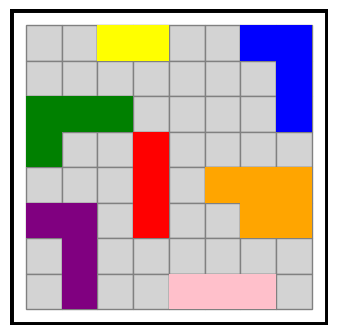

To a state incorporating the following block position(s):


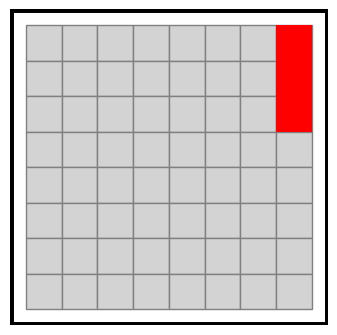


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..
:-)) *SUCCESS* ((-:

Path length = 2065
Goal state is:


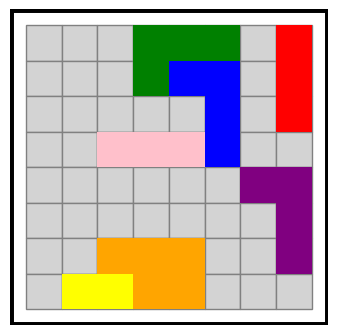


SEARCH SPACE STATS:
Total nodes generated          =    28463  (includes start)
Nodes discarded by loop_check  =     4205  (24258 distinct states added to queue)
Nodes tested (by goal_test)    =     2066  (2065 expanded + 1 goal)
Nodes left in queue            =    22192

Time taken = 2.3492 seconds

Solve the following sliding blocks problem.
Get from this initial state:


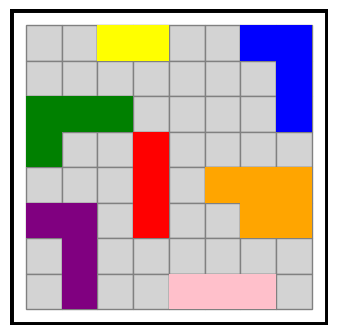

To a state incorporating the following block position(s):


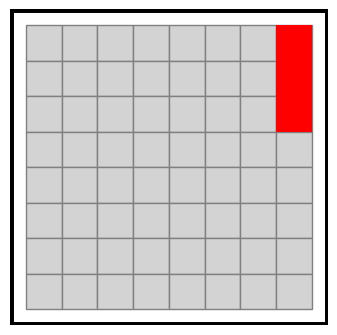


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   636742  (includes start)
Nodes discarded by loop_check  =   536741  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39159  (all expanded)
Nodes left in queue            =    60841

Time taken = 20.3728 seconds

Solve the following sliding blocks problem.
Get from this initial state:


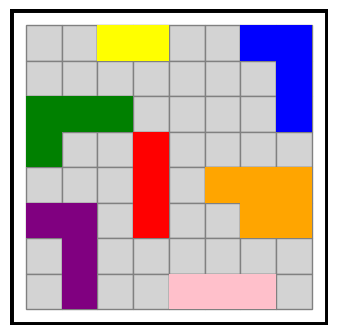

To a state incorporating the following block position(s):


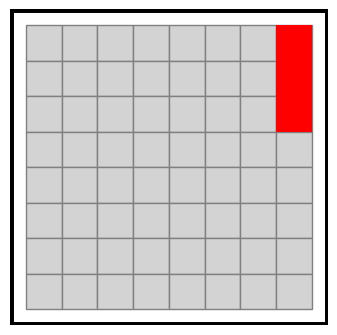


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 85
Goal state is:


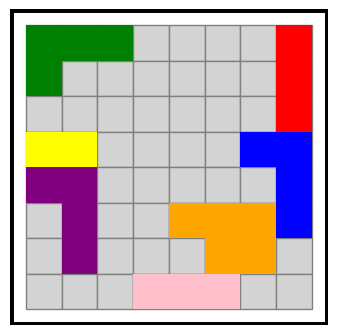


SEARCH SPACE STATS:
Total nodes generated          =     1187  (includes start)
Nodes discarded by loop_check  =      174  (1013 distinct states added to queue)
Nodes tested (by goal_test)    =       86  (85 expanded + 1 goal)
Nodes left in queue            =      927

Time taken = 0.0864 seconds

Solve the following sliding blocks problem.
Get from this initial state:


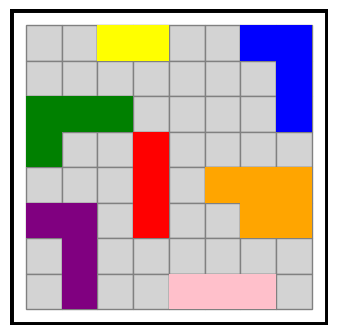

To a state incorporating the following block position(s):


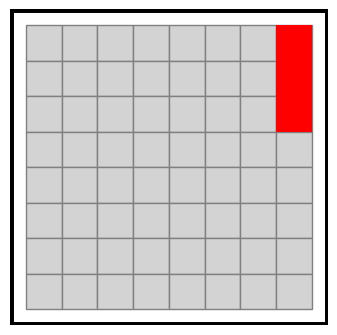


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121188  (includes start)
Nodes discarded by loop_check  =    21187  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9801  (all expanded)
Nodes left in queue            =    90199

Time taken = 21.1822 seconds

Solve the following sliding blocks problem.
Get from this initial state:


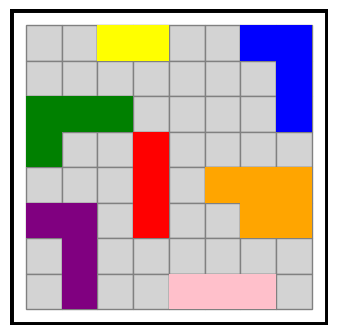

To a state incorporating the following block position(s):


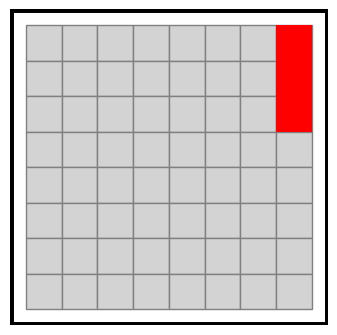


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 266
Goal state is:


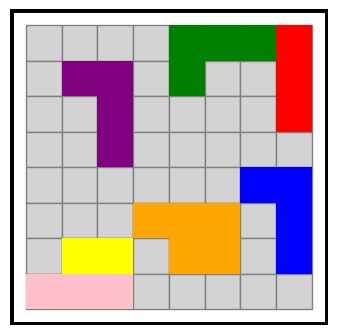


SEARCH SPACE STATS:
Total nodes generated          =     3531  (includes start)
Nodes discarded by loop_check  =      539  (2992 distinct states added to queue)
Nodes tested (by goal_test)    =      267  (266 expanded + 1 goal)
Nodes left in queue            =     2725

Time taken = 0.1809 seconds

Solve the following sliding blocks problem.
Get from this initial state:


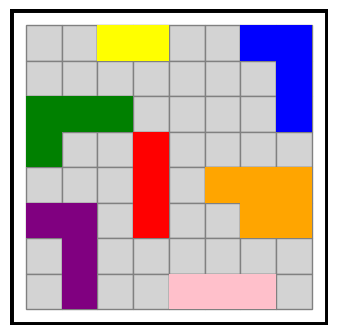

To a state incorporating the following block position(s):


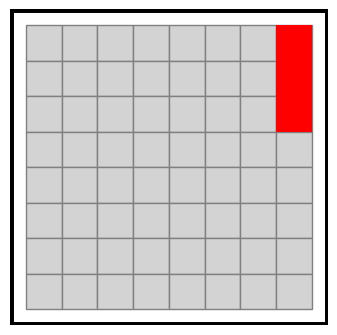


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
........
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


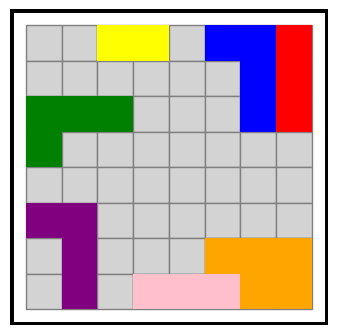

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   142163  (includes start)
Nodes discarded by loop_check  =   108693  (33470 distinct states added to queue)
Nodes tested (by goal_test)    =     8697  (8696 expanded + 1 goal)
Nodes left in queue            =    24773

Time taken = 23.1035 seconds

Solve the following sliding blocks problem.
Get from this initial state:


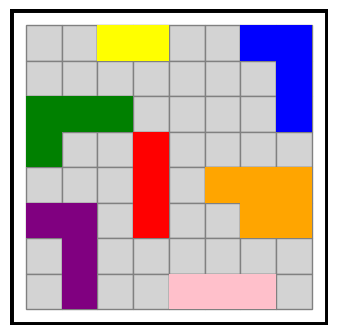

To a state incorporating the following block position(s):


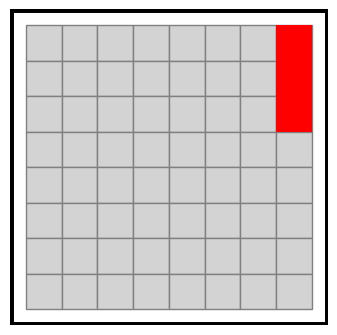


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   569917  (includes start)
Nodes discarded by loop_check  =   469916  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35471  (all expanded)
Nodes left in queue            =    64529

Time taken = 19.2624 seconds

Solve the following sliding blocks problem.
Get from this initial state:


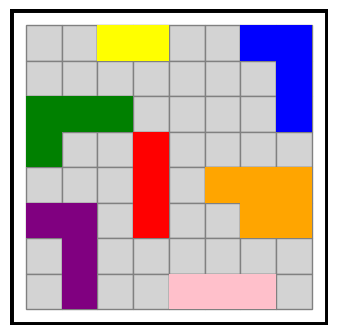

To a state incorporating the following block position(s):


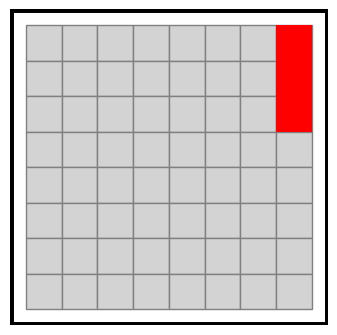


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...............................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   514128  (includes start)
Nodes discarded by loop_check  =   414127  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    31559  (all expanded)
Nodes left in queue            =    68441

Time taken = 18.4005 seconds

Solve the following sliding blocks problem.
Get from this initial state:


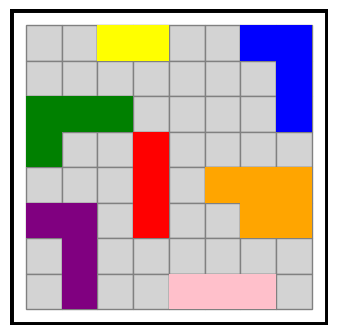

To a state incorporating the following block position(s):


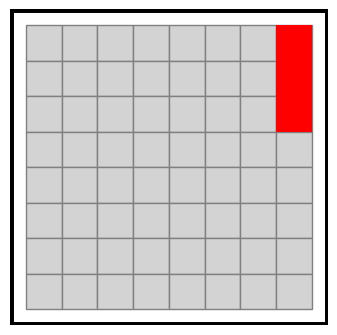


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 1855
Goal state is:


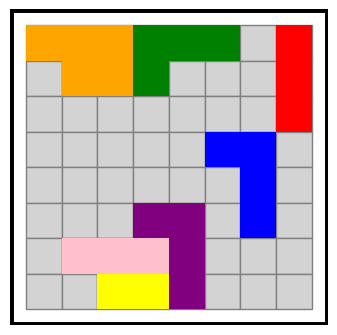


SEARCH SPACE STATS:
Total nodes generated          =    26061  (includes start)
Nodes discarded by loop_check  =     3799  (22262 distinct states added to queue)
Nodes tested (by goal_test)    =     1856  (1855 expanded + 1 goal)
Nodes left in queue            =    20406

Time taken = 2.2157 seconds

Solve the following sliding blocks problem.
Get from this initial state:


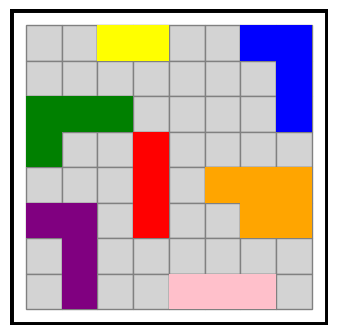

To a state incorporating the following block position(s):


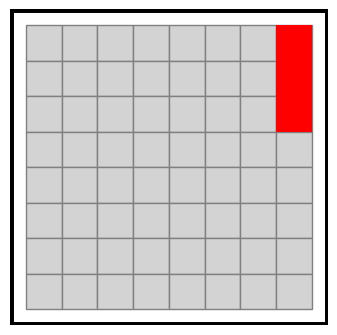


** Running Brandon's Search Algorithm **
Strategy: mode=BF, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.......................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   639065  (includes start)
Nodes discarded by loop_check  =   539064  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    39695  (all expanded)
Nodes left in queue            =    60305

Time taken = 20.4967 seconds

Solve the following sliding blocks problem.
Get from this initial state:


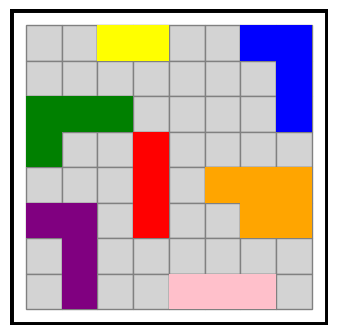

To a state incorporating the following block position(s):


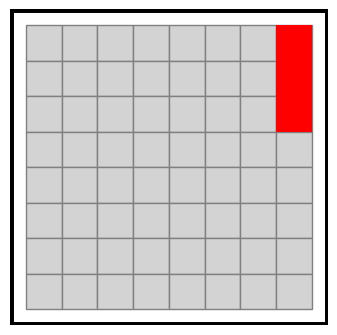


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 173
Goal state is:


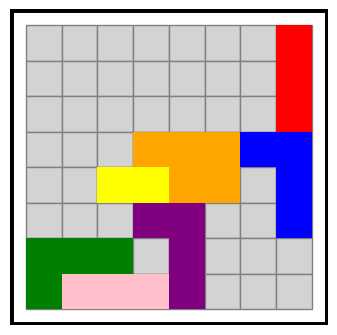


SEARCH SPACE STATS:
Total nodes generated          =     2383  (includes start)
Nodes discarded by loop_check  =      363  (2020 distinct states added to queue)
Nodes tested (by goal_test)    =      174  (173 expanded + 1 goal)
Nodes left in queue            =     1846

Time taken = 0.1291 seconds

Solve the following sliding blocks problem.
Get from this initial state:


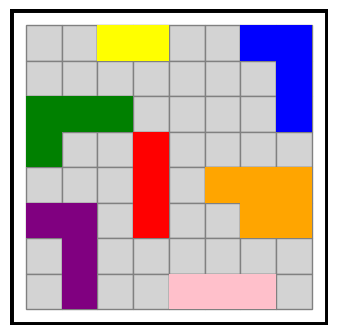

To a state incorporating the following block position(s):


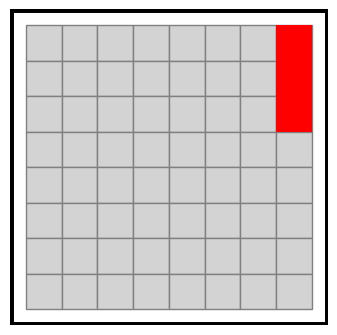


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   121112  (includes start)
Nodes discarded by loop_check  =    21111  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9857  (all expanded)
Nodes left in queue            =    90143

Time taken = 21.3642 seconds

Solve the following sliding blocks problem.
Get from this initial state:


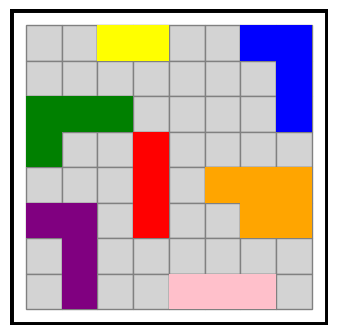

To a state incorporating the following block position(s):


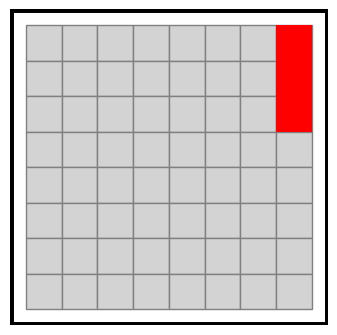


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=None, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.........
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   120706  (includes start)
Nodes discarded by loop_check  =    20705  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =     9678  (all expanded)
Nodes left in queue            =    90322

Time taken = 40.6861 seconds

Solve the following sliding blocks problem.
Get from this initial state:


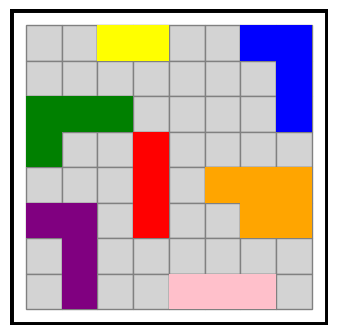

To a state incorporating the following block position(s):


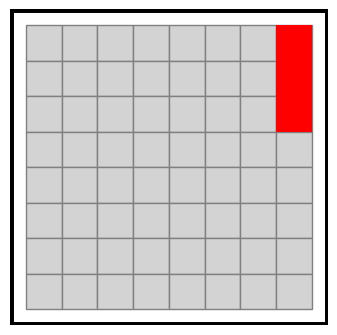


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=manhatten_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
..............
:-)) *SUCCESS* ((-:

Path length = 11
Goal state is:


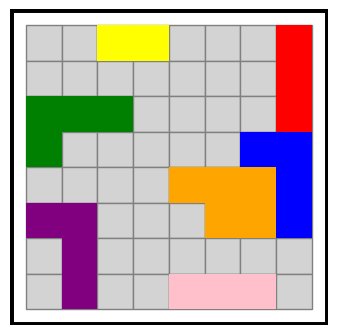

Cost of reaching goal: 11

SEARCH SPACE STATS:
Total nodes generated          =   240451  (includes start)
Nodes discarded by loop_check  =   191936  (48515 distinct states added to queue)
Nodes tested (by goal_test)    =    14952  (14951 expanded + 1 goal)
Nodes left in queue            =    33563

Time taken = 26.3417 seconds

Solve the following sliding blocks problem.
Get from this initial state:


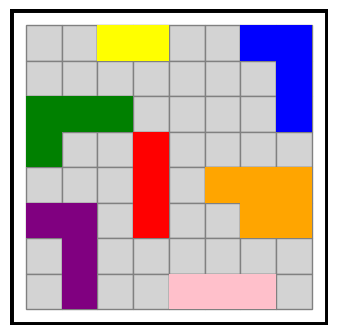

To a state incorporating the following block position(s):


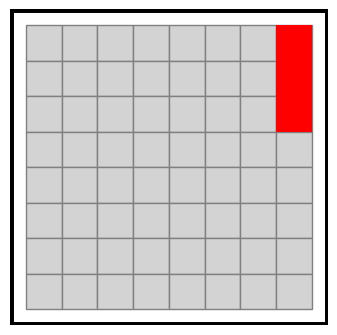


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=euclidean_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   570327  (includes start)
Nodes discarded by loop_check  =   470326  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    35506  (all expanded)
Nodes left in queue            =    64494

Time taken = 19.5077 seconds

Solve the following sliding blocks problem.
Get from this initial state:


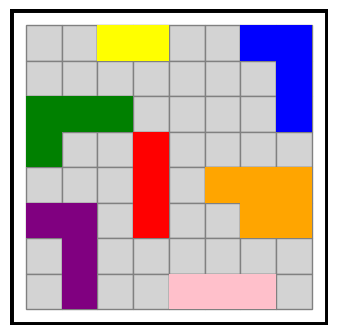

To a state incorporating the following block position(s):


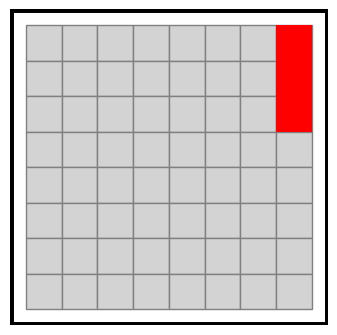


** Running Brandon's Search Algorithm **
Strategy: mode=DF, cost=cost, heuristic=chebyshev_heuristic
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................................
!! Search node limit (100000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =   521213  (includes start)
Nodes discarded by loop_check  =   421212  (100001 distinct states added to queue)
Nodes tested (by goal_test)    =    32110  (all expanded)
Nodes left in queue            =    67890

Time taken = 18.692 seconds



In [8]:
iterations = 10
puzzle = big_puzzle

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

# Define the search types and their corresponding parameters
search_types = {
    'DF': {'search_type': 'DF', 'heuristic': None, 'cost': None},
    'BF': {'search_type': 'BF', 'heuristic': None, 'cost': None},
    'Best_M': {'search_type': 'DF', 'heuristic': manhatten_heuristic, 'cost': None},
    'Best_E': {'search_type': 'DF', 'heuristic': euclidean_heuristic, 'cost': None},
    'Best_C': {'search_type': 'DF', 'heuristic': chebyshev_heuristic, 'cost': None},
    'A*_M': {'search_type': 'DF', 'heuristic': manhatten_heuristic, 'cost': puzzle.cost},
    'A*_E': {'search_type': 'DF', 'heuristic': euclidean_heuristic, 'cost': puzzle.cost},
    'A*_C': {'search_type': 'DF', 'heuristic': chebyshev_heuristic, 'cost': puzzle.cost}
}

# Initialize accumulators for each search
search_stats = {search_type: {'max_nodes': 0, 'ng': 0, 'nq': 0, 'time': 0, 'termination_condition': 'SEARH-SPACE_EXHAUSTED'} for search_type in search_types}

for _ in range(iterations):
    for search_type, params in search_types.items():
        # Perform the search
        search_result = search(puzzle, params['search_type'], 100000, loop_check=True, randomise=True, show_state_path=False, return_info=True, show_path=False, heuristic=params['heuristic'], cost=params['cost'])

        # Update the stats
        search_stats[search_type]['max_nodes'] += search_result['args']['max_nodes']
        search_stats[search_type]['ng'] += search_result['search_stats']['nodes_generated']
        search_stats[search_type]['nq'] += search_result['search_stats']['nodes_left_in_queue']
        search_stats[search_type]['time'] += round(search_result['search_stats']['time_taken'], 8)

        # Update termination condition
        if search_result['result']['termination_condition'] == 'GOAL_STATE_FOUND':
            search_stats[search_type]['termination_condition'] = 'GOAL_STATE_FOUND'
        elif search_result['result']['termination_condition'] == 'NODE_LIMIT_EXCEEDED' and search_stats[search_type]['termination_condition'] != 'GOAL_STATE_FOUND':
            search_stats[search_type]['termination_condition'] = 'NODE_LIMIT_EXCEEDED'

# Calculate averages
for search_type in search_types:
    search_stats[search_type]['max_nodes'] /= iterations
    search_stats[search_type]['ng'] /= iterations
    search_stats[search_type]['nq'] /= iterations
    search_stats[search_type]['time'] /= iterations


# Calculate averages
for search_type in search_types:
    search_stats[search_type]['max_nodes'] /= iterations
    search_stats[search_type]['ng'] /= iterations
    search_stats[search_type]['nq'] /= iterations
    search_stats[search_type]['time'] /= iterations

In [9]:
# Print the results
print("\n                **AVERAGES**\n")
print(f"{'Test':<10} {'#max':<10} {'Result':<10} {'#gen':<10} {'#inQ':<10} {'Time s':<15} {'Termination':<15}")
for search_type, stats in search_stats.items():
    print(f"{search_type:<10} {stats['max_nodes']:<10.2f} {short_tc[stats['termination_condition']]:<10} {stats['ng']:<10.2f} {stats['nq']:<10.2f} {stats['time']:<15.8f} {stats['termination_condition']:<15}")


                **AVERAGES**

Test       #max       Result     #gen       #inQ       Time s          Termination    
DF         10000.00   Y          3525.15    2748.29    0.33593955      GOAL_STATE_FOUND
BF         10000.00   !          64055.00   6046.74    2.12907546      NODE_LIMIT_EXCEEDED
Best_M     10000.00   Y          1376.19    1032.30    0.21004550      GOAL_STATE_FOUND
Best_E     10000.00   !          12110.38   9017.32    2.27687766      NODE_LIMIT_EXCEEDED
Best_C     10000.00   Y          9713.64    7249.67    3.40060413      GOAL_STATE_FOUND
A*_M       10000.00   Y          18245.75   2839.34    2.46787132      GOAL_STATE_FOUND
A*_E       10000.00   !          57057.71   6448.78    1.89211232      NODE_LIMIT_EXCEEDED
A*_C       10000.00   !          52271.35   6788.93    1.82942189      NODE_LIMIT_EXCEEDED


In [10]:
'''heuristicNoneTime = 0
heuristicTime = 0
heuristicNonePathLength = 0
heuristicPathLength = 0

for _ in range(1):
    small_search = search( big_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False, 
                        return_info=True, show_path=False, heuristic=None)
    heuristicNoneTime += small_search["search_stats"]["time_taken"]

    if type(small_search["result"]["path_length"]) is int:
        heuristicNonePathLength += small_search["result"]["path_length"]

    small_search_heuristic = search( big_puzzle, 'DF', 100000, loop_check=True, randomise=True, show_state_path=False,
                        return_info=True, show_path=False, heuristic=euclidean_heuristic)
    heuristicTime += small_search_heuristic["search_stats"]["time_taken"]
    
    if type(small_search_heuristic["result"]["path_length"]) is int:
        heuristicPathLength += small_search_heuristic["result"]["path_length"]

print("No Heuristic: ", heuristicNoneTime/1)
print("Heuristic: ", heuristicTime/1)
print("Path length: ", heuristicNonePathLength/1)
print("Path length: ", heuristicPathLength/1)'''

'heuristicNoneTime = 0\nheuristicTime = 0\nheuristicNonePathLength = 0\nheuristicPathLength = 0\n\nfor _ in range(1):\n    small_search = search( big_puzzle, \'DF\', 100000, loop_check=True, randomise=True, show_state_path=False, \n                        return_info=True, show_path=False, heuristic=None)\n    heuristicNoneTime += small_search["search_stats"]["time_taken"]\n\n    if type(small_search["result"]["path_length"]) is int:\n        heuristicNonePathLength += small_search["result"]["path_length"]\n\n    small_search_heuristic = search( big_puzzle, \'DF\', 100000, loop_check=True, randomise=True, show_state_path=False,\n                        return_info=True, show_path=False, heuristic=euclidean_heuristic)\n    heuristicTime += small_search_heuristic["search_stats"]["time_taken"]\n    \n    if type(small_search_heuristic["result"]["path_length"]) is int:\n        heuristicPathLength += small_search_heuristic["result"]["path_length"]\n\nprint("No Heuristic: ", heuristicNoneTi